# [6] Blender Dataset Training
## 1. argument 생성

In [134]:
import os
import cv2
import time
import json
import random
import numpy as np
import imageio.v2 as imageio

import torch
import torch.nn as nn
import torch.nn.functional as F

import argparse
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [135]:
print(os.getcwd())

/home/white/Desktop/white/NeRF


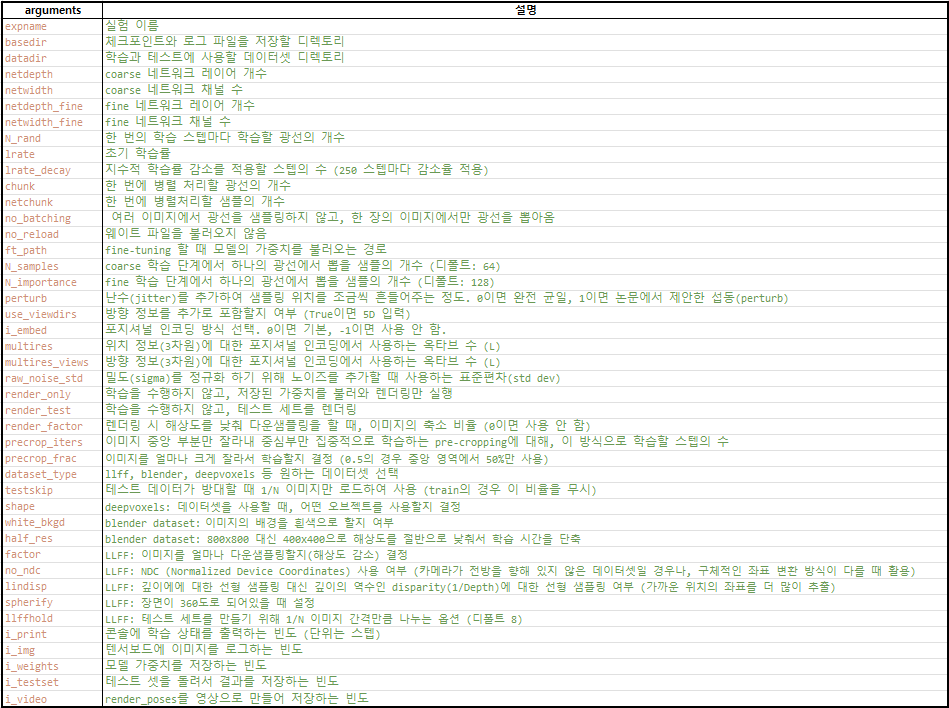

In [136]:
# 이 함수는 `argparse.ArgumentParser` 객체를 생성하고, 그 안에 여러 인자를 추가한 뒤, 최종적으로 파서(parser) 객체를 리턴합니다.  
# 다른 곳에서 `config_parser()`를 호출하여, 그 결과로 리턴된 `parser` 객체를 통해 명령줄 인자를 파싱하게 됩니다.
def config_parser():
    parser = argparse.ArgumentParser() # parser라는 이름의 ArgumentParser 객체 생성

    parser.add_argument("--expname", type=str, 
                        help='experiment name') # 실험 이름
    parser.add_argument("--basedir", type=str, default='./logs/', 
                        help='where to store ckpts and logs') # 체크포인트와 로그 파일을 저장할 디렉토리
    parser.add_argument("--datadir", type=str, default='./data/llff/fern', 
                        help='input data directory') # 학습과 테스트에 사용할 데이터셋 디렉토리

    # training options
    parser.add_argument("--netdepth", type=int, default=8, # coarse 네트워크 레이어 개수
                        help='layers in network')
    parser.add_argument("--netwidth", type=int, default=256, # coarse 네트워크 채널 수
                        help='channels per layer')
    parser.add_argument("--netdepth_fine", type=int, default=8, # fine 네트워크 레이어 개수
                        help='layers in fine network')
    parser.add_argument("--netwidth_fine", type=int, default=256, 
                        help='channels per layer in fine network') # fine 네트워크 채널 수
    parser.add_argument("--N_rand", type=int, default=32*32*4, 
                        help='batch size (number of random rays per gradient step)') # 한 번의 학습 스텝마다 학습할 광선의 개수
    parser.add_argument("--lrate", type=float, default=5e-4, 
                        help='learning rate') # 초기 학습률
    parser.add_argument("--lrate_decay", type=int, default=250, 
                        help='exponential learning rate decay (in 1000 steps)') # 지수적 학습률 감소를 적용할 스텝의 수 (250 스텝마다 감소율 적용)
    parser.add_argument("--chunk", type=int, default=1024*32, 
                        help='number of rays processed in parallel, decrease if running out of memory') # 한 번에 병렬 처리할 광선의 개수
    parser.add_argument("--netchunk", type=int, default=1024*64, 
                        help='number of pts sent through network in parallel, decrease if running out of memory') # 한 번에 병렬처리할 샘플의 개수
    parser.add_argument("--no_batching", action='store_true', 
                        help='only take random rays from 1 image at a time') # 여러 이미지에서 광선을 샘플링하지 않고, 한 장의 이미지에서만 광선을 뽑아옴
    parser.add_argument("--no_reload", action='store_true', 
                        help='do not reload weights from saved ckpt') # 웨이트 파일을 불러오지 않음
    parser.add_argument("--ft_path", type=str, default=None, 
                        help='specific weights npy file to reload for coarse network') # fine-tuning 할 때 모델의 가중치를 불러오는 경로

    # rendering options
    parser.add_argument("--N_samples", type=int, default=64, 
                        help='number of coarse samples per ray') # coarse 학습 단계에서 하나의 광선에서 뽑을 샘플의 개수 (디폴트: 64)
    parser.add_argument("--N_importance", type=int, default=0,
                        help='number of additional fine samples per ray') # fine 학습 단계에서 하나의 광선에서 뽑을 샘플의 개수 (디폴트: 128)
    parser.add_argument("--perturb", type=float, default=1.,
                        help='set to 0. for no jitter, 1. for jitter') # 난수(jitter)를 추가하여 샘플링 위치를 조금씩 흔들어주는 정도. 0이면 완전 균일, 1이면 논문에서 제안한 섭동(perturb)
    parser.add_argument("--use_viewdirs", action='store_true', 
                        help='use full 5D input instead of 3D') # 방향 정보를 추가로 포함할지 여부 (True이면 5D 입력)
    parser.add_argument("--i_embed", type=int, default=0, 
                        help='set 0 for default positional encoding, -1 for none') # 포지셔널 인코딩 방식 선택. 0이면 기본, -1이면 사용 안 함.
    parser.add_argument("--multires", type=int, default=10, 
                        help='log2 of max freq for positional encoding (3D location)') # 위치 정보(3차원)에 대한 포지셔널 인코딩에서 사용하는 옥타브 수 (L)
    parser.add_argument("--multires_views", type=int, default=4, 
                        help='log2 of max freq for positional encoding (2D direction)') # 방향 정보(3차원)에 대한 포지셔널 인코딩에서 사용하는 옥타브 수 (L)
    parser.add_argument("--raw_noise_std", type=float, default=0., 
                        help='std dev of noise added to regularize sigma_a output, 1e0 recommended') # 밀도(sigma)를 정규화 하기 위해 노이즈를 추가할 때 사용하는 표준편차(std dev)

    parser.add_argument("--render_only", action='store_true', 
                        help='do not optimize, reload weights and render out render_poses path') # 학습을 수행하지 않고, 저장된 가중치를 불러와 렌더링만 실행
    parser.add_argument("--render_test", action='store_true', 
                        help='render the test set instead of render_poses path') # 학습을 수행하지 않고, 테스트 세트를 렌더링
    parser.add_argument("--render_factor", type=int, default=0, 
                        help='downsampling factor to speed up rendering, set 4 or 8 for fast preview') # 렌더링 시 해상도를 낮춰 다운샘플링을 할 때, 이미지의 축소 비율 (0이면 사용 안 함)

    # training options
    parser.add_argument("--precrop_iters", type=int, default=0,
                        help='number of steps to train on central crops') # 이미지 중앙 부분만 잘라내 중심부만 집중적으로 학습하는 pre-cropping에 대해, 이 방식으로 학습할 스텝의 수
    parser.add_argument("--precrop_frac", type=float,
                        default=.5, help='fraction of img taken for central crops') # 이미지를 얼마나 크게 잘라서 학습할지 결정 (0.5의 경우 중앙 영역에서 50%만 사용)

    # dataset options
    parser.add_argument("--dataset_type", type=str, default='llff', 
                        help='options: llff / blender / deepvoxels') # llff, blender, deepvoxels 등 원하는 데이터셋 선택
    parser.add_argument("--testskip", type=int, default=8, 
                        help='will load 1/N images from test/val sets, useful for large datasets like deepvoxels') # 테스트 데이터가 방대할 때 1/N 이미지만 로드하여 사용 (train의 경우 이 비율을 무시)

    ## deepvoxels flags
    parser.add_argument("--shape", type=str, default='greek', 
                        help='options : armchair / cube / greek / vase') # deepvoxels 데이터셋을 사용할 때, 어떤 오브젝트를 사용할지 결정

    ## blender flags
    parser.add_argument("--white_bkgd", action='store_true', 
                        help='set to render synthetic data on a white bkgd (always use for dvoxels)') # 이미지의 배경을 흰색으로 할지 여부
    parser.add_argument("--half_res", action='store_true', 
                        help='load blender synthetic data at 400x400 instead of 800x800') # 800x800 대신 400x400으로 해상도를 절반으로 낮춰서 학습 시간을 단축

    ## llff flags
    parser.add_argument("--factor", type=int, default=8, 
                        help='downsample factor for LLFF images') # LLFF 이미지를 얼마나 다운샘플링할지(해상도 감소) 결정.
    parser.add_argument("--no_ndc", action='store_true', 
                        help='do not use normalized device coordinates (set for non-forward facing scenes)') # NDC (Normalized Device Coordinates) 사용 여부 (카메라가 전방을 향해 있지 않은 데이터셋일 경우나, 구체적인 좌표 변환 방식이 다를 때 활용)
    parser.add_argument("--lindisp", action='store_true', 
                        help='sampling linearly in disparity rather than depth') # 깊이에에 대한 선형 샘플링 대신 깊이의 역수인 disparity(1/Depth)에 대한 선형 샘플링 여부 (가까운 위치의 좌표를 더 많이 추출)
    parser.add_argument("--spherify", action='store_true', 
                        help='set for spherical 360 scenes') # 장면이 360도로 되어있을 때 설정
    parser.add_argument("--llffhold", type=int, default=8, 
                        help='will take every 1/N images as LLFF test set, paper uses 8') # LLFF에서 테스트 세트를 만들기 위해 1/N 이미지 간격만큼 나누는 옵션 (디폴트 8)

    # logging/saving options
    parser.add_argument("--i_print",   type=int, default=100, 
                        help='frequency of console printout and metric loggin') # 콘솔에 학습 상태를 출력하는 빈도 (단위는 스텝)
    parser.add_argument("--i_img",     type=int, default=500, 
                        help='frequency of tensorboard image logging') # 텐서보드에 이미지를 로그하는 빈도
    parser.add_argument("--i_weights", type=int, default=10000, 
                        help='frequency of weight ckpt saving') # 모델 가중치를 저장하는 빈도
    parser.add_argument("--i_testset", type=int, default=50000, 
                        help='frequency of testset saving') # 테스트 셋을 돌려서 결과를 저장하는 빈도
    parser.add_argument("--i_video",   type=int, default=50000,
                        help='frequency of render_poses video saving') # render_poses를 영상으로 만들어 저장하는 빈도

    return parser

In [137]:
parser = config_parser() # 위에서 정의한 config_parser() 함수를 호출해 객체 생성
args = parser.parse_args(args=[]) # args = []를 통해 모든 인자가 디폴트 값인채로 args 객체 생성
args.config = 'configs/lego.txt' # args에 config라는 속성을 추가. (설정 파일의 경로 지정)

"""
<configs/lego.txt>
expname = blender_paper_lego
basedir = ./logs
datadir = ./data/nerf_synthetic/lego
dataset_type = blender

no_batching = True

use_viewdirs = True
white_bkgd = True
lrate_decay = 500

N_samples = 64
N_importance = 128
N_rand = 1024

precrop_iters = 500
precrop_frac = 0.5

half_res = True
"""

'\n<configs/lego.txt>\nexpname = blender_paper_lego\nbasedir = ./logs\ndatadir = ./data/nerf_synthetic/lego\ndataset_type = blender\n\nno_batching = True\n\nuse_viewdirs = True\nwhite_bkgd = True\nlrate_decay = 500\n\nN_samples = 64\nN_importance = 128\nN_rand = 1024\n\nprecrop_iters = 500\nprecrop_frac = 0.5\n\nhalf_res = True\n'

In [138]:
parser = config_parser() # 먼저 config_parser() 함수를 호출해 parser(ArgumentParser 객체)를 받습니다.
args = parser.parse_args(args=[]) # parse_args(args=[])는 빈 리스트를 인자로 넘기는 것이므로, 실제로는 명령줄 인자를 주지 않은 채 모든 인자를 기본값으로 파싱합니다.

# args.config라는 속성을 추가로 지정하여, config_parser에서 정의된 인자 외에 **‘config’**라는 속성을 하나 더 줍니다.
# 'configs/lego.txt'라는 텍스트 파일(설정 파일) 경로를 저장해 둡니다.
args.config = 'configs/lego.txt'
# load config
with open(args.config, 'r') as fp: # lego.txt 파일 불러오기
    lines = fp.readlines() # fp.readlines()로 모든 줄을 읽어 lines 리스트를 얻습니다.
    lines = [line.strip() for line in lines] # line.strip()을 통해 앞뒤 공백을 제거하고,
    lines = [line.split(' = ') for line in lines if len(line)>0] # ' = '을 기준으로 split해서 ['expname', 'lego'] 같은 구조로 만듭니다. (단순히 ' = ' 구분자를 사용해 key/value로 나누는 방식)

configs = {} # 그런 다음 configs = {} 딕셔너리를 만든 뒤
for line in lines: # 각 줄(line)을 순회하면서
    configs[line[0]] = line[1] # configs[line[0]] = line[1]로 key-value 형태로 저장합니다.

for key, value in configs.items():
    print(f"{key}: {value}")

expname: blender_paper_lego
basedir: ./logs
datadir: ./data/nerf_synthetic/lego
dataset_type: blender
no_batching: True
use_viewdirs: True
white_bkgd: True
lrate_decay: 500
N_samples: 64
N_importance: 128
N_rand: 1024
precrop_iters: 500
precrop_frac: 0.5
half_res: True


In [139]:
args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']
args.no_batching = configs['no_batching']
args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.precrop_iters = int(configs['precrop_iters'])
args.precrop_frac = float(configs['precrop_frac'])
args.half_res = configs['half_res']
args.no_reload = True

for key, value in vars(args).items():
    print(f"{key}: {value}")

device = torch.device("cuda")
DEBUG=False
print(device)

expname: blender_paper_lego
basedir: ./logs
datadir: ./data/nerf_synthetic/lego
netdepth: 8
netwidth: 256
netdepth_fine: 8
netwidth_fine: 256
N_rand: 1024
lrate: 0.0005
lrate_decay: 500
chunk: 32768
netchunk: 65536
no_batching: True
no_reload: True
ft_path: None
N_samples: 64
N_importance: 128
perturb: 1.0
use_viewdirs: True
i_embed: 0
multires: 10
multires_views: 4
raw_noise_std: 0.0
render_only: False
render_test: False
render_factor: 0
precrop_iters: 500
precrop_frac: 0.5
dataset_type: blender
testskip: 8
shape: greek
white_bkgd: True
half_res: True
factor: 8
no_ndc: False
lindisp: False
spherify: False
llffhold: 8
i_print: 100
i_img: 500
i_weights: 10000
i_testset: 50000
i_video: 50000
config: configs/lego.txt
cuda


## 2. 블렌더 데이터셋 분석

In [140]:
# Z축으로 t만큼 이동
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

# X축 기준 phi만큼 회전
rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

# Y축 기준 -theta만큼 회전
rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius) # Z축으로 t만큼 이동
    c2w = rot_phi(phi/180.*np.pi) @ c2w # X축으로 phi만큼 회전
    c2w = rot_theta(theta/180.*np.pi) @ c2w # Y축으로 -theta만큼 회전
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w # world 좌표계 x-axis를 반대로, y-axis & z-axis 바꾸기
    # 즉 X축으로 -phi, Y축으로 -theta만큼 회전한 후 Y, Z축 바꾸기
    # look at point는 보통 원점, 혹은 원점 근처. 따라서 camera 가 바라보는 방향은 camera 의 - z-axis
    return c2w

In [141]:
# data practice
_datadir = './data/nerf_synthetic/lego'

with open(os.path.join(_datadir, 'transforms_train.json'), 'r') as fp:
    meta = json.load(fp)

_frames = meta['frames']
_frame = _frames[0]
print(_frame) # 하나의 이미지에 대한 메타 데이터

_fname = os.path.join(_datadir, _frame['file_path']+'.png')
print(_fname) # 이미지 파일 경로

img = imageio.imread(_fname)
print(img.shape) # 4 channel rgba

print(len(meta['frames'])) # 이미지는 총 100장

rotations = []
transform_matrixes = []

for i in range(len(meta['frames'])):
    rotations.append(meta['frames'][i]['rotation'])
    transform_matrixes.append(meta['frames'][i]['transform_matrix'])

print(rotations)
print(transform_matrixes)

{'file_path': './train/r_0', 'rotation': 0.012566370614359171, 'transform_matrix': [[-0.9999021887779236, 0.004192245192825794, -0.013345719315111637, -0.05379832163453102], [-0.013988681137561798, -0.2996590733528137, 0.95394366979599, 3.845470428466797], [-4.656612873077393e-10, 0.9540371894836426, 0.29968830943107605, 1.2080823183059692], [0.0, 0.0, 0.0, 1.0]]}
./data/nerf_synthetic/lego/./train/r_0.png
(800, 800, 4)
100
[0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171,

(10, 800, 800, 4)


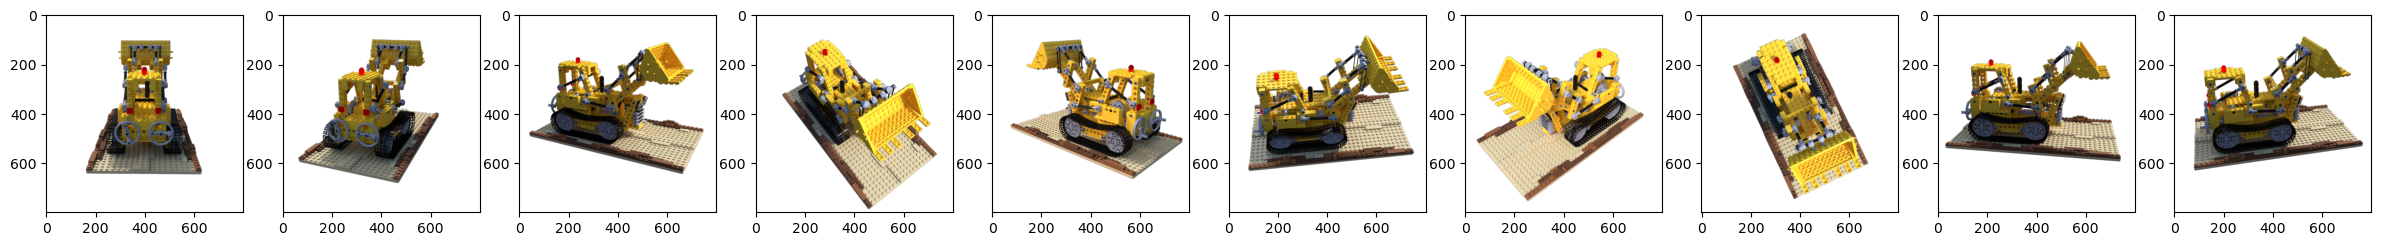

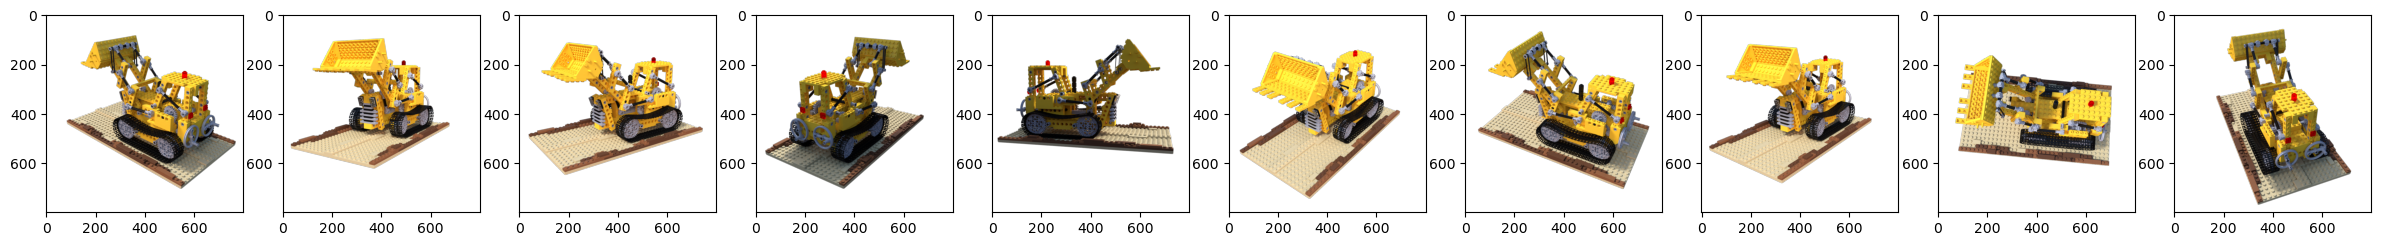

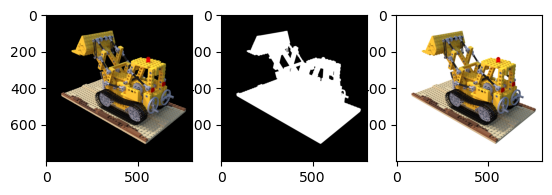

In [142]:
fig, axis = plt.subplots(1, 10, figsize=(30,300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame['file_path']+'.png')
    img = imageio.imread(_fname)
    axis[i].imshow(img)

random.shuffle(_frames)
fig, axis = plt.subplots(1, 10, figsize=(30,300))
imgs = []
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame['file_path']+'.png')
    img = imageio.imread(_fname)
    imgs.append(img)
    axis[i].imshow(img)

imgs = (np.array(imgs) / 255.).astype(np.float32)
print(imgs.shape)

imgs_orig = imgs[...,:3] # rgb값만 저장
imgs_mask = imgs[...,-1] # 불투명도값만 저장
imgs = imgs[...,:3]*imgs[...,-1:] + (1-imgs[...,-1:]) # 흰 배경으로

fig, axis = plt.subplots(1,3)
axis[0].imshow(imgs_orig[0])
axis[1].imshow(imgs_mask[0], cmap='gray')
axis[2].imshow(imgs[0])

In [143]:
def load_blender_data(basedir, half_res=False, testskip=1):
    splits = ['train', 'val', 'test']

    metas = {} # 메타 정보는 여기에 저장한다.
    for s in splits:
        with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
            metas[s] = json.load(fp)
    # {'train' : 'transforms_train_json', ...}

    all_imgs = [] # train, test, val의 모든 이미지를 넣는 리스트
    all_poses = [] # 카메라 포즈에 대한 모든 행렬을 넣는 리스트
    counts = [0]

    for s in splits: # train, val, test
        meta = metas[s]
        imgs = []
        poses = []
        if s=='train' or testskip==0:
            skip = 1 # train 데이터를 만들 때는 하나도 건너뛰지 않고 모두 저장
        else:
            skip = testskip # train이 아닐 경우 testskip만큼 건너 뛰면서 데이터 샘플링 진행

        for frame in meta['frames'][::skip]:
            fname = os.path.join(basedir, frame['file_path'] + '.png') # 이미지 파일 경로를 리스트에 저장
            imgs.append(imageio.imread(fname)) # 이미지를 리스트에 저장
            poses.append(np.array(frame['transform_matrix'])) # cam to world 매트릭스를 리스트에 저장

        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0]) # start index, end of train index, end of val index, end of test index
        # counts = [0, 200, 210, 220]

        # for문 이전에 선언한 모든 데이터셋을 담아둘 리스트에 이미지와 c2w 매트릭스 저장
        all_imgs.append(imgs)
        all_poses.append(poses)
    
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)] # index for each split(train, val, test)
    
    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)
    
    H, W = imgs[0].shape[:2] # 이미지의 세로, 가로축 길이
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    # focal lenth = (1/2 * width) / (tan(1/2 * theta)) (theta = camera_angle_x)
    
    render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,120+1)[:-1]], 0)
    # render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
    # rendering 할 pose 미리 정의
    # pose_spherical를 통해 cam to world 매트릭스를 만든다.
    # 첫 번째 인자 angle은 X축 좌우 회전 각도 (-180부터 180까지)
    # 두 번째 인자는 Y축 기준 30도 회전 (pose_sherical은 X, Y의 회전 각도가 반대!)

    # 이미지를 1/2 스케일로 줄이는 것 (학습 속도를 높이기 위함)
    if half_res:
        H = H//2
        W = W//2
        # important - change focal
        focal = focal/2. # 이미지가 작아지면 focal도 당연히 1/2가 된다!

        imgs_half_res = np.zeros((imgs.shape[0], H, W, 4))
        for i, img in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res

        
    return imgs, poses, render_poses, [H, W, focal], i_split

images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)

In [144]:
# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]
print(hwf)

[400, 400, 555.5555155968841]


In [145]:
print(i_split) # 이중 어레이
print(i_split[0][0]) # train 이미지 첫 인덱스 (100장)
print(i_split[1][0]) # val 이미지 첫 인덱스 (13장)
print(i_split[2][0]) # test 이미지 첫 인덱스 (20장)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]), array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137])]
0
100
113


In [146]:
print(len(images)) # train, val, test 전체 이미지 개수
print(images[0].shape)
print(len(poses)) # train, val, test 전체 c2w 개수
print(poses[0])

138
(400, 400, 4)
138
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [147]:
print(len(render_poses))
print(render_poses[0])

120
tensor([[ 1.0000e+00,  6.1232e-17, -1.0606e-16, -4.2423e-16],
        [-1.2246e-16,  5.0000e-01, -8.6603e-01, -3.4641e+00],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  2.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


In [148]:
print(H)
print(W)
print(focal)
print(hwf)

400
400
555.5555155968841
[400, 400, 555.5555155968841]


In [149]:
K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])
print(K)

[[555.5555156   0.        200.       ]
 [  0.        555.5555156 200.       ]
 [  0.          0.          1.       ]]


In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
from pytransform3d.plot_utils import plot_vector

def plot_cam(figsize, poses, elev, azim, axis_lim, plot_label):
    # 3D 플롯 생성
    fig = plt.figure(figsize=(figsize, figsize))
    ax = fig.add_subplot(111, projection='3d')

    # 월드 좌표계 그리기
    pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.3, name="World")

    # 보기 편하도록 뷰 설정
    ax.view_init(elev=elev, azim=azim)

    # 카메라 위치 저장용 배열 (최대/최소 좌표 계산)
    all_camera_positions = []

    for i, c2w in enumerate(poses):
        try:
            c2w = np.array(c2w) # 텐서를 넘파이로 변환
            # 카메라 좌표계 플롯
            if plot_label:
                ax = pt.plot_transform(A2B=c2w, ax=ax, s=0.3, name=f"Step {i}")  # s 값 조정
                # 카메라 프러스텀 플롯 (가상 이미지 거리 키움)
                pc.plot_camera(
                    ax=ax,
                    cam2world=c2w,
                    M=K,
                    virtual_image_distance=0.1,
                    label=f"Step {i}",
                    color="red",
                    alpha=0.5
                )

            else:
                ax = pt.plot_transform(A2B=c2w, ax=ax, s=0.3)
                pc.plot_camera(
                    ax=ax,
                    cam2world=c2w,
                    M=K,
                    virtual_image_distance=0.1,
                    color="red",
                    alpha=0.5
                )
        except:
            continue

    ax.set_xlim([-axis_lim, axis_lim])
    ax.set_ylim([-axis_lim, axis_lim])
    ax.set_zlim([-axis_lim, axis_lim])

    ax.set_box_aspect((1, 1, 1))  # 축 비율 균일화
    # ax.auto_scale_xyz(all_camera_positions[:, 0], all_camera_positions[:, 1], all_camera_positions[:, 2])  # 자동 스케일 조정

    plt.show()

# plot_cam(9, poses, 10, 45, 3, False)

# 3. 데이터셋으로부터 광선 생성

In [151]:
# --- 토이 프로젝트 ---
H_ = 4
W_ = 6

# torch.linspace(0,W-1,W): 0부터 W까지 W-1개의 1씩 증가하는 1차원 텐서 생성 [0, 1, 2, ... W-1]
i = torch.linspace(0, W_-1, W_)
j = torch.linspace(0, H_-1, H_)
i, j = torch.meshgrid(i, j)
print(i) # (W, H)
print(j) # (W, H)

i = i.t()
j = j.t()

print(i) # (H, W)
print(j) # (H, W)

# 텐서 i, j를 마지막 차원에 새 축으로 쌓음.
# 즉, 각 픽셀 위치마다 (i, j) 두 좌표를 [i, j] 형태로 묶어, shape가 (H, W, 2)인 텐서가 됩니다.
# 예: grid[y, x] = [i_value, j_value].
grid = torch.stack([i, j], dim = -1)
print(grid[0]) # 0번째 row의 좌표들
print(grid[0][0]) # 0번째 row, 0번째 column의 좌표
print(grid[3][4]) # 3번째 row, 4번째 column의 좌표 (x, y) = (j, i)!

tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.],
        [4., 4., 4., 4.],
        [5., 5., 5., 5.]])
tensor([[0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.]])
tensor([[0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.]])
tensor([[0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3.]])
tensor([[0., 0.],
        [1., 0.],
        [2., 0.],
        [3., 0.],
        [4., 0.],
        [5., 0.]])
tensor([0., 0.])
tensor([4., 3.])


In [152]:
def visualize_image_and_normal_plane(H, W, K, axis_lim):
    """
    Image Plane과 Normal Plane을 각각의 3D 그래프에서 시각화하는 함수.
    """
    # --- 이미지 플레인의 좌표 지정 ---
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W),
        torch.linspace(0, H-1, H)
    )
    i = i.t()
    j = j.t()

    # --- Image Plane 계산 ---
    img_plane_x = i
    img_plane_y = j
    img_plane_z = torch.full_like(i, K[0][0])  # focal length x로 가정
    img_plane = torch.stack([img_plane_x, img_plane_y, img_plane_z], dim=-1)  # (H,W,3)
    img_plane_flat = img_plane.view(-1, 3).cpu().numpy()

    # --- Normal Plane 계산 ---
    norm_plane_x = (img_plane_x-K[0][2])/K[0][0]
    norm_plane_y = (img_plane_y-K[1][2])/K[1][1]
    norm_plane_z = torch.ones_like(img_plane_x)
    dirs = torch.stack([norm_plane_x, -norm_plane_y, -norm_plane_z], -1)  # (H, W, 3)
    dirs_flat = dirs.view(-1, 3).cpu().numpy()

    # --- Image plane 모서리 좌표 가져오기 ---
    img_corner_points = torch.stack([
        img_plane[0, 0],        # 좌상단 (Top-Left)
        img_plane[0, W-1],      # 우상단 (Top-Right)
        img_plane[H-1, 0],      # 좌하단 (Bottom-Left)
        img_plane[H-1, W-1]     # 우하단 (Bottom-Right)
    ], dim=0).cpu().numpy()

    # --- Normal plane 모서리 좌표 가져오기 ---
    corner_points = torch.stack([
        dirs[0, 0],        # 좌상단 (Top-Left)
        dirs[0, W-1],      # 우상단 (Top-Right)
        dirs[H-1, 0],      # 좌하단 (Bottom-Left)
        dirs[H-1, W-1]     # 우하단 (Bottom-Right)
    ], dim=0).cpu().numpy()

    # --- 두 개의 3D 플롯 생성 ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': '3d'})

    # --- (1) Image Plane 시각화 ---
    ax1 = axes[0]
    ax1.set_title("Image Plane")
    # pt.plot_transform(ax=ax1, A2B=np.eye(4), s=0.3, name="CameraCoord")

    ax1.scatter(img_plane_flat[:, 0], img_plane_flat[:, 1], img_plane_flat[:, 2],
                c='green', s=5, alpha=0.5, label="Image plane")
    
    ax1.scatter(img_corner_points[:, 0], img_corner_points[:, 1], img_corner_points[:, 2],
                c='red', s=50, marker='o', label="Corners")

    # 모서리 좌표 텍스트 추가
    for i, (x, y, z) in enumerate(img_corner_points):
        ax1.text(x, y, z, f"({x:.2f}, {y:.2f}, {z:.2f})",
                 color="red", fontsize=9, ha="center")

    ax1.view_init(elev=45, azim=-60)
    ax1.legend()
    ax1.set_xlim([0, W])
    ax1.set_ylim([0, H])
    ax1.set_zlim([0, K[0][0] + 5])
    ax1.set_box_aspect((1, 1, 1))

    # --- (2) Normal Plane 시각화 ---
    ax2 = axes[1]
    ax2.set_title("Normal Plane")
    # pt.plot_transform(ax=ax2, A2B=np.eye(4), s=0.3, name="CameraCoord")

    ax2.scatter(dirs_flat[:, 0], dirs_flat[:, 1], dirs_flat[:, 2],
                c='blue', s=5, alpha=0.6, label="Normal plane")

    ax2.scatter(corner_points[:, 0], corner_points[:, 1], corner_points[:, 2],
                c='red', s=50, marker='o', label="Corners")

    # 모서리 좌표 텍스트 추가
    for i, (x, y, z) in enumerate(corner_points):
        ax2.text(x, y, z, f"({x:.2f}, {y:.2f}, {z:.2f})",
                 color="red", fontsize=9, ha="center")

    ax2.view_init(elev=45, azim=-60)
    ax2.legend()
    ax2.set_xlim([-axis_lim, axis_lim])
    ax2.set_ylim([-axis_lim, axis_lim])
    ax2.set_zlim([-2, 0])
    ax2.set_box_aspect((1, 1, 1))

    plt.show()

# # 실행 예시
# visualize_image_and_normal_plane(H, W, K, 0.4)

In [153]:
def visulaize_normal_plane(H, W, K, axis_lim):
    # 이미지 플레인의 좌표 지정
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W),
        torch.linspace(0, H-1, H)
    )
    i = i.t()
    j = j.t()

    img_plane_x = i
    img_plane_y = j
    img_plane_z = torch.full_like(i, K[0][0]) # z는 focal length x로 가정 (focal length x와 focal length y는 동일한 값이므로)
    img_plane = torch.stack([img_plane_x, img_plane_y, img_plane_z], dim=-1)  # (H,W,3)
    img_plane_flat = img_plane.view(-1, 3).cpu().numpy()

    norm_plane_x = (img_plane_x-K[0][2])/K[0][0]
    norm_plane_y = (img_plane_y-K[1][2])/K[1][1]
    norm_plane_z = torch.ones_like(img_plane_x)
    dirs = torch.stack([norm_plane_x, -norm_plane_y, -norm_plane_z], -1) # (H, W, 3)
    dirs_flat = dirs.view(-1, 3).cpu().numpy()

    # --- Normal plane 모서리 좌표 가져오기 ---
    corner_points = torch.stack([
        dirs[0, 0],        # 좌상단 (Top-Left)
        dirs[0, W-1],      # 우상단 (Top-Right)
        dirs[H-1, 0],      # 좌하단 (Bottom-Left)
        dirs[H-1, W-1]     # 우하단 (Bottom-Right)
    ], dim=0).cpu().numpy()

    corner_labels = ["Top-Left", "Top-Right", "Bottom-Left", "Bottom-Right"]

    # --- 시각화 시작 ---
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.1, name="CameraCoord")

    # --- Normal plane 산점도 ---
    ax.scatter(dirs_flat[:, 0], dirs_flat[:, 1], dirs_flat[:, 2],
               c='blue', s=5, alpha=0.6, label="Normal plane (z=-1)")

    # --- 모서리 좌표 추가 (빨간색 점) ---
    ax.scatter(corner_points[:, 0], corner_points[:, 1], corner_points[:, 2],
               c='red', s=50, marker='o', label="Corners")

    # --- 원점에서 모서리로 향하는 벡터 추가 ---
    for i, (x, y, z) in enumerate(corner_points):
        ax.quiver(0, 0, 0, x, y, z, color='green', arrow_length_ratio=0.1, label="Corner Vectors" if i == 0 else "")

    # --- 모서리 좌표 라벨 추가 ---
    for i, (x, y, z) in enumerate(corner_points):
        ax.text(x, y, z, f"{corner_labels[i]}\n({x:.2f}, {y:.2f}, {z:.2f})", 
                color="black", fontsize=10, ha="center")

    # --- 시각화 설정 ---
    ax.view_init(elev=30, azim=-120)
    ax.legend()
    ax.set_xlim([-axis_lim, axis_lim])
    ax.set_ylim([-axis_lim, axis_lim])
    ax.set_zlim([-2, 0])

    ax.set_box_aspect((1, 1, 1))  # 축 비율 균일화
    plt.show()

# visulaize_normal_plane(H, W, K, 0.5)

In [154]:
def get_rays_np(H, W, K, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -np.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # dirs[..., np.newaxis, :]
    # 원본 dirs가 (H,W,3).
    # [..., np.newaxis, :] → shape (H,W,1,3).

    # c2w[:3,:3]
    # 카메라->월드 행렬에서 3×3 회전부분(R).
    # shape (3,3).

    # 원소별 곱
    # (H,W,1,3) × (3,3)에서 브로드캐스팅으로 “각 픽셀 방향벡터” × “회전행렬 R”을 수행.

    # np.sum(..., -1)
    # 마지막 축(-1=3)에 대해 합 => “dot product”와 동일한 결과.
    # 결과 shape: (H,W,3).
    # 즉, 카메라 좌표에서의 방향을 월드 좌표로 회전시킨 방향 벡터.

    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    # c2w[:3, -1] = t, 즉 카메라 월드 좌표계에서의 원점(평행이동). shape = (3,).
    # np.shape(rays_d) = (H,W,3).
    # np.broadcast_to(..., (H,W,3))
    # => 카메라의 원점(3D) 값을 (H,W,3)로 복사(모든 픽셀 동일 origin).
    # 따라서 rays_o[y,x,:] 전부 t
    # 최종 shape: (H,W,3).

    return rays_o, rays_d

In [155]:
pose = poses[0] # (4, 4)
print(pose[:3, :3]) # c2w의 회전행렬 R (3, 3)
print(pose[:3, -1]) # c2w의 평행이동 t (3, )
print(pose[-1]) # 동차 좌표계에서 4x4 꼴을 맞추기 위해 붙여둔 [ 0 0 0 1 ]

pose = pose[:3, :4] # 의미 없는 [ 0 0 0 1 ]는 제외하고 get_rays_np() 함수의 입력값으로 사용
print(pose)

[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01]]
[-0.05379832  3.8454704   1.2080823 ]
[0. 0. 0. 1.]
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]]


In [156]:
rays_o, rays_d = get_rays_np(H, W, K, pose)

In [157]:
print(rays_o[0, 0]) # [i, j]의 모든 값이 c2w 행렬에 의해 원점이 이동한 좌표로 동일
print(rays_d[0, 0]) # [i, j]좌표에 대응하는 노말 평면 상의 좌표가 c2w 행렬에 의해 이동한 좌표

[-0.05379832  3.8454704   1.2080823 ]
[ 0.37481973 -1.056785    0.0437651 ]


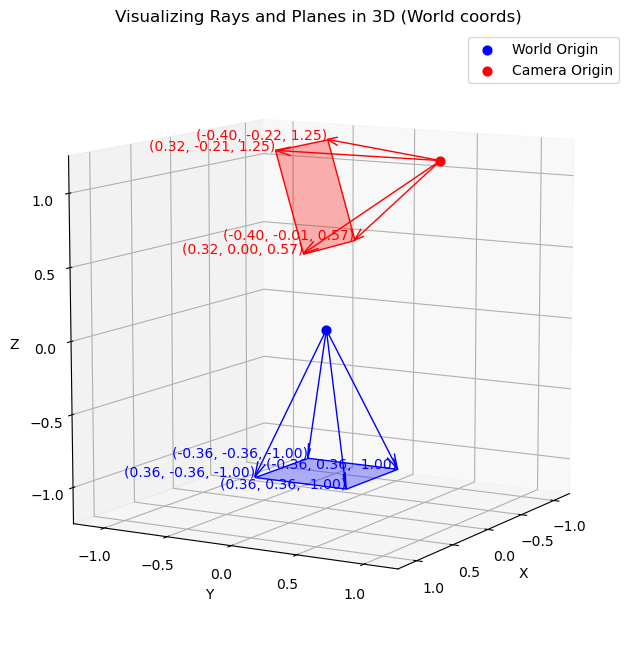

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def get_rays_from_dirs_np(H, W, K, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32),
                       indexing='xy')
    dirs = np.stack([
        (i - K[0, 2]) / K[0, 0],
        -(j - K[1, 2]) / K[1, 1],
        -np.ones_like(i)
    ], axis=-1)  # (H, W, 3)

    rays_d = np.sum(dirs[..., None, :] * c2w[:3, :3], axis=-1)  # (H, W, 3)
    rays_o = np.broadcast_to(c2w[:3, -1], rays_d.shape)  # (H, W, 3)

    return dirs, rays_o, rays_d

def visualize_rays_3d(H, W, K, c2w, axis_lim=2, elev=30, azim=45):
    dirs, rays_o, rays_d = get_rays_from_dirs_np(H, W, K, c2w)

    corner_indices = [(0, 0), (0, W-1), (H-1, W-1), (H-1, 0)]  # 네 벡터를 시계 방향으로 저장
    cam_origin_camera_coord = np.broadcast_to(np.array([[0, 0, 0]]), (4, 3))
    dirs_corners = np.array([dirs[i, j] for i, j in corner_indices])
    rays_o_corners = np.array([rays_o[i, j] for i, j in corner_indices])
    rays_d_corners = np.array([rays_d[i, j] for i, j in corner_indices])

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    world_origin = np.array([0, 0, 0])
    ax.scatter(*world_origin, c='blue', s=40, label="World Origin")

    for ro, rd in zip(cam_origin_camera_coord, dirs_corners):
        ax.quiver(*ro, *rd, color='blue', linewidth=1, arrow_length_ratio=0.1)
        endpoint = ro + rd
        ax.text(*endpoint, f'({endpoint[0]:.2f}, {endpoint[1]:.2f}, {endpoint[2]:.2f})',
                color='blue', fontsize=10, ha='right')
        
    cam_origin = c2w[:3, 3]
    ax.scatter(*cam_origin, c='red', s=40, label="Camera Origin")
        
    for ro, rd in zip(rays_o_corners, rays_d_corners):
        ax.quiver(*ro, *rd, color='red', linewidth=1, arrow_length_ratio=0.1)
        endpoint = ro + rd
        ax.text(*endpoint, f'({endpoint[0]:.2f}, {endpoint[1]:.2f}, {endpoint[2]:.2f})',
                color='red', fontsize=10, ha='right')
    
    normal_plane_camera = dirs_corners
    normal_plane_world = cam_origin + rays_d_corners

    ax.add_collection3d(Poly3DCollection([normal_plane_camera], color='blue', alpha=0.3))
    ax.add_collection3d(Poly3DCollection([normal_plane_world], color='red', alpha=0.3))

    ax.set_xlim([-axis_lim, axis_lim])
    ax.set_ylim([-axis_lim, axis_lim])
    ax.set_zlim([-axis_lim, axis_lim])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect((1, 1, 1))
    ax.legend()
    plt.title("Visualizing Rays and Planes in 3D (World coords)")
    ax.view_init(elev=elev, azim=azim)
    plt.show()

if __name__ == "__main__":
    H, W = 400, 400
    K = np.array([
        [555.5555, 0., 200.],
        [0., 555.5555, 200.],
        [0., 0., 1.]
    ], dtype=np.float32)

    c2w = np.array([
        [-0.99990219, 0.00419225, -0.01334572, -0.05379832],
        [-0.01398868, -0.29965907, 0.95394367, 0.84547042],
        [-0.0, 0.95403719, 0.29968831, 1.20808232],
        [0., 0., 0., 1.]
    ], dtype=np.float32)

    visualize_rays_3d(H, W, K, c2w, axis_lim=1.2, elev=10, azim=30)

In [159]:
# 위의 get_rays_np와 동일한 연산을 하지만, output이 numpy array가 아닌 tensor
def get_rays(H, W, K, c2w):
    # 이미지 플레인의 좌표 지정
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W),
        torch.linspace(0, H-1, H)
    )
    i = i.t()
    j = j.t()

    img_plane_x = i
    img_plane_y = j
    img_plane_z = torch.full_like(i, K[0][0]) # z는 focal length x로 가정 (focal length x와 focal length y는 동일한 값이므로)
    img_plane = torch.stack([img_plane_x, img_plane_y, img_plane_z], dim=-1)  # (H,W,3)
    img_plane_flat = img_plane.view(-1, 3).cpu().numpy()

    norm_plane_x = (img_plane_x-K[0][2])/K[0][0]
    norm_plane_y = (img_plane_y-K[1][2])/K[1][1]
    norm_plane_z = torch.ones_like(img_plane_x)
    dirs = torch.stack([norm_plane_x, -norm_plane_y, -norm_plane_z], -1) # (H, W, 3)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1) # # c2w @ dir  c2w.dot(dir) dot product, equals to: [c2w.dot(dir) for dir in dirs]
    rays_o = c2w[:3, -1].expand(rays_d.shape)

    return rays_o, rays_d

# LLFF 데이터셋을 NDC 좌표계로 정규화 하는 코드
def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # Shift ray origins to near plane
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d
    
    # Projection
    o0 = -1./(W/(2.*focal)) * rays_o[...,0] / rays_o[...,2]
    o1 = -1./(H/(2.*focal)) * rays_o[...,1] / rays_o[...,2]
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - rays_o[...,0]/rays_o[...,2])
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - rays_o[...,1]/rays_o[...,2])
    d2 = -2. * near / rays_o[...,2]
    
    rays_o = torch.stack([o0,o1,o2], -1)
    rays_d = torch.stack([d0,d1,d2], -1)
    
    return rays_o, rays_d

# 4. NeRF 모델 생성

In [160]:
import torch
# torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Positional encoding (section 5.1)
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs # “몇 차원의 입력을 받을지?”, “몇 개의 주파수를 사용할지?”, “어떤 함수를 쓸지?(sin, cos 등)” 등의 정보가 담긴 아규먼트를 받는다.
        self.create_embedding_fn() # 바로 create_embedding_fn()을 호출하여 실제 인코딩 함수를 만든다.
        
    def create_embedding_fn(self):
        embed_fns = [] # 임베딩 할 함수들을 담는 리스트
        d = self.kwargs['input_dims'] # 입력 차원. view dir과 카메라 위치 좌표 모두 3차원이다.
        out_dim = 0 # 최종 Positional Encoding의 출력 차원을 추적하기 위한 변수로, 초기 값은 0으로 세팅.

        if self.kwargs['include_input']: # 단순히 인풋 값을 아웃풋에 추가할 것인지.
            embed_fns.append(lambda x : x) # 인코딩 벡터에 인풋값인 X, Y, Z 좌표를 추가해준다. (즉, 60차원이 아닌 63차원으로 return)
            out_dim += d # out_dim에 3 더하여 추적 업데이트.

        # L과 L-1을 정해준다. (하단의 embed_kwargs 참조)
        max_freq = self.kwargs['max_freq_log2'] # 최대 주파수 max_freq = Octave-1 = L-1
        N_freqs = self.kwargs['num_freqs'] # 주파수 개수 N_freqs = Octave = L

        if self.kwargs['log_sampling']: # 로그 샘플링
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
            # 0부터 max_freq(=L-1)까지 N_freqs개를 2의 제곱에 모두 태우는 것.
        else: # 리니어 샘플링
            freq_bands = torch.linspace(2.**0, 2.**max_freq, step=N_freqs)
            # 0부터 max_freq(L-1)까지 N_freqs개를 단순히 리니어 샘플링 한다.
            # 실제 코드는 있으나 사용하진 않음.

        # 예: max_freq_log2=9, num_freqs=10 → freq_bands = [1, 2, 4, 8, ..., 512(=2^9)]

        # 이제 sin, cos에 태워준다.
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']: # 어떤 함수에 태울 것인가? (논문에선 cos, sin 사용)
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq)) # 수식에는 π까지 붙이는데 여기선 그냥 sin(2^n * x), cos(2^n * x)
                # cf) lambda (input : output)
                out_dim += d

        # 이후 클래스의 다른 함수에서 접근할 수 있도록 self 변수에 대입
        self.embed_fns = embed_fns # 포지션 인코딩에 사용할 람다 함수 리스트 (x, sin, cos, ... , sin, cos)
        self.out_dim = out_dim # 포지션 인코딩 된 값의 차원

    # embed_fns에 input 데이터를 넣어 임베딩 된 결과를 도출한 뒤, torch.cat으로 묶어서 반환해주는 함수
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)
        # 여러 개의 람다 함수를 순회하며, 입력벡터 inputs에 대해 각각 사인·코사인을 계산.   
        # 마지막 차원(-1)으로 연결(torch.cat), 즉 shape가 (N, out_dim) 형태가 됨.

        # 예:
        # 입력이 shape (N,3)
        # 주파수 대역이 L=10, include_input=True라면,
        # 최종 출력은 (N, 63).

### get_embedder
이 함수는 위에서 선언한 임베더 클래스의 내부 함수들을 실행시켜 결과를 받아내는 역할을 한다.  
이렇게 선언된 클래스에서 인스턴스를 생성하고, 내부 함수를 수행하는 함수를 헬퍼 함수라고도 부른다.  
헬퍼 함수는 외부 코드에서 직접 인스턴스를 만들고 일일이 인자들을 세팅하는 과정을 하나의 명령어로 컨트롤할 수 있기 때문에 다양한 변인을 바꿔줘야 하는 실험 세팅에 편리함을 준다.  

input:  
- mulitres: 옥타브 수
- i: 포지셔널 인코딩 사용 여부

output:
- embed: 포지셔널 임베딩을 진행할 함수
- embedder_obj.out_dim: 포지셔널 임베딩 된 벡터의 차원

In [161]:
# 위에서 정의한 임베더 클래스에서 객체를 생성한 후, view_o와 view_d를 구분하여 임베딩 해주는 함수.
# view_o와 view_d의 옥타브 (L = multires)의 값이 각각 다르다.
def get_embedder(multires, i = 0): # multires는 옥타브 수
    # 만약 i=-1, 즉 “positional encoding을 쓰지 않겠다”는 상황이면, 항등 함수(nn.Identity())와 출력차원 3을 반환.
    if i == -1:
        return nn.Identity(), 3 # 그냥 같은 값 return.
    
    # -1이 아닌 경우
    # 임베더 인스턴스를 생성하기 전에, 이것이 생성자(__init__)에서 받는 kwargs를 생성해준다.
    embed_kwargs = {
                'include_input' : True, # 원래 input 값을 output에 넣을 것이냐? (60 -> 63)
                'input_dims' : 3, # input_dim은 view_o와 view_d 모두 3차원으로 동일.
                'max_freq_log2' : multires-1, # L - 1
                'num_freqs' : multires, # = L (옥타브 수). 이 값은 
                'log_sampling' : True, # 지수함수에 태울 것인가
                'periodic_fns' : [torch.sin, torch.cos], # 어떤 주기함수에 태울 것인가
    }
    
    embedder_obj = Embedder(**embed_kwargs) # 객체 생성 후 위에서 정의한 kwargs로 초기화
    embed = lambda x, eo=embedder_obj : eo.embed(x) # 임베딩 된 결과값
    
    # embed는 positional encoding 된 값, embedder_obj.out_dim는 예를 들어 63이 나올 것
    return embed, embedder_obj.out_dim

In [162]:
# 카메라 좌표 (X, Y, Z)를 옥타브 10에 태워 임베딩 하는 예제
embed, out_dim = get_embedder(10,0) # 옥타브 10
# embed: 임베딩 함수
# outdim: 임베딩 차원수
print(embed)
print(out_dim)

input = torch.rand(3)
# embed 함수로 인스턴스 생성부터 결과값
output = embed(input) # 처음 3개는 같고, 그 다음 60개는 sin, cos을 태운 것.

print(input)
print(output)

<function get_embedder.<locals>.<lambda> at 0x7fc95d7caca0>
63
tensor([0.7279, 0.8369, 0.7113])
tensor([ 0.7279,  0.8369,  0.7113,  0.6653,  0.7426,  0.6528,  0.7465,  0.6698,
         0.7575,  0.9934,  0.9947,  0.9890,  0.1147, -0.1028,  0.1476,  0.2278,
        -0.2045,  0.2920, -0.9737, -0.9789, -0.9564, -0.4437,  0.4003, -0.5585,
         0.8962,  0.9164,  0.8295, -0.7952,  0.7336, -0.9266,  0.6063,  0.6796,
         0.3761, -0.9643,  0.9971, -0.6969, -0.2648, -0.0764, -0.7172,  0.5107,
        -0.1523,  0.9996, -0.8597, -0.9883,  0.0286, -0.8782,  0.3011,  0.0572,
         0.4783,  0.9536, -0.9984, -0.8401,  0.5743, -0.1142, -0.5425,  0.8187,
         0.9935,  0.9114,  0.9403, -0.2269, -0.4115,  0.3404,  0.9739])


In [163]:
# view_dirs를 옥타브 4에 태워 임베딩 하는 예제
embed, out_dim = get_embedder(4, 0) # 뷰 디렉션의 옥타브는 4
print(embed)
print(out_dim)

output = embed(input)

print(input)
print(output)

<function get_embedder.<locals>.<lambda> at 0x7fc95d7caee0>
27
tensor([0.7279, 0.8369, 0.7113])
tensor([ 0.7279,  0.8369,  0.7113,  0.6653,  0.7426,  0.6528,  0.7465,  0.6698,
         0.7575,  0.9934,  0.9947,  0.9890,  0.1147, -0.1028,  0.1476,  0.2278,
        -0.2045,  0.2920, -0.9737, -0.9789, -0.9564, -0.4437,  0.4003, -0.5585,
         0.8962,  0.9164,  0.8295])


### NeRF 네트워크

입력 데이터:
- x.shape = **(B, 63 + 27)**
- **각 샘플 포인트**의 **rays_o 임베딩 벡터**와 **rays_d 임베딩 벡터**가 두 번째 차원에서 concat
- 여기서 B는 모든 샘플 포인트 수  **(N_rays * N_samples)** 를 배치 단위

출력 데이터:
- return.shape = **(B, 4)**
- 각 샘플 포인트의 RGB 값과 불투명도 값


네트워크 임베딩 시퀀스:
- rays_o의 임베딩 벡터만 첫 번째 레이어에 임베딩 됨
- 5번째 레이어에서 해당 벡터를 skip connect 하여 정보 희석 방지 
- 마지막 레이어에서 해당 픽셀의 투명도를 산출  
- rays_d의 임베딩 벡터와 rays_o의 임베딩 벡터를 concat 한 벡터가 마지막 레이어에 임베딩 됨
- 이 정보에 대한 아웃풋으로 RGB값을 산출

In [164]:
# Model
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4, skips=[4], use_viewdirs=False): # output_ch=4인 이유는 rgb와 alpha의 4개이므로.
        super(NeRF, self).__init__()
        # 생성자로 받은 인자를 클래스 내부 변수로 저장
        self.D = D # 네트워크의 총 레이어
        self.W = W # 은닉 레이어 너비(채널 수)
        self.input_ch = input_ch # 뷰 위치 차원
        self.input_ch_views = input_ch_views # 뷰 디렉션 차원
        self.skips = skips # 스킵 커넥션 레이어
        self.use_viewdirs = use_viewdirs # 뷰 디렉션 사용 여부 (사용)

        # 위치 좌표의 입력을 처리하는 레이어
        self.pts_linears = nn.ModuleList([nn.Linear(input_ch, W)] +
                                         [nn.Linear(W, W) if i not in self.skips else nn.Linear(W+input_ch, W) for i in range(D-1)])
        # 스킵 레이어가 아니라면 단순히 W -> W 레이어
        # 스킵 레이어라면 W + input_ch -> W 레이어
        # 스킵 커넥션의 성능: 깊은 레이어에서도 초기 입력 좌표의 고주파 정보를 계속 사용할 수 있게 됩니다.

        # 시점 방향 입력을 처리하는 레이어
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W//2)])
        # W + input_ch_view -> W 레이어

        if use_viewdirs: # view_dirs를 사용한다면
            self.feature_linear = nn.Linear(W, W) # W -> W 레이어
            self.alpha_linear = nn.Linear(W, 1) # 하나의 스칼라 값인 알파값을 뽑기 위한 1채널
            self.rgb_linear = nn.Linear(W//2,3) # rgb output을 뽑기 위한 3채널
        else: # view_dirs를 사용하지 않는다면
            # 단일 레이어 (W -> 4)로 RGB값과 알파 값을 같이 추출
            self.output_linear = nn.Linear(W, output_ch) # rgb 알파까지 해서 4채널

    def forward(self, x): # x.shape = (B, 63 + 27), 이 때, B는 전체 포인트 N_rays * N_samples를 chunk 단위로 나눈 것이다.
        # input x에는 좌표에 대한 인코딩 값인 self.input_ch와 view dir에 대한 인코딩 값인 self.input_ch_views이 concat 되어있다.
        # 따라서 우선 이걸 torch.split를 dim = -1 (마지막 dim)에서 나눠준다.
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1) # (B, 63), (B, 27)
        
        # input_pts: 인코딩된 광선 원점
        # 이를 for문을 돌면서 변형될 h에 대입하는 이유는, skip connection layer에서 input_pts를 concat 해주기 위함이다.
        h = input_pts
        # 인덱스 4 레이어에서 h를 한 번 더 concat 하니까 인덱스를 알기 위해 enum 사용
        for i, l in enumerate(self.pts_linears):
            h = self.pts_linears[i](h) # i번째 레이어에 h를 넣고
            h = F.relu(h) # relu 태워주기
            if i in self.skips: # 인덱스가 self.skips에 포함된다면
                h = torch.cat([input_pts, h], -1) # (B, 63+256)
        
        # 현재 h: 위치 좌표에 대한 W 차원의 output

        # view dirs의 사용 여부(논문에선 사용)
        if self.use_viewdirs:
            alpha = self.alpha_linear(h) # for loop를 다 돌고 나온 h에 self.alpha_linear를 통과시켜 투명도인 alpha를 생성
            
            # h를 다시 feature layer에 통과시켜 변형
            feature = self.feature_linear(h) # for loop를 다 돌고 나온 h에 self.feature_linear를 통과시켜 feature를 생성
            h = torch.cat([feature, input_views], -1) # feature_linear를 input_views와 concat
            # 위치와 방향 두 가지 정보를 조합해서 rgb 컬러 값을 낸다.
            # 보는 방향이 달라졌을 때, 빛의 반사 등에 의해 같은 지점의 색상도 다르게 보일 수 있으니 방향 정보를 concat 하는 것

            # views_linears를 거쳐 최종 rgb값 산출
            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            # 마지막 rgb 레이어 (256 to 128)
            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], -1)
        else:
            outputs = self.output_linear(h) # view dir를 사용하지 않을 경우 단일 레이어에서 rgb, alpha 모두 얻음.
        
        return outputs

In [165]:
# 인풋 값 생성
input_pts = torch.rand(1,3) # 배치 1, input은 x, y, z로 3
input_dir = torch.rand(1,3) # 배치 1, dir도 3
print(input_pts)
print(input_dir)

# 임베딩 하기
embed_func_pts, out_dim_pts = get_embedder(10) # 좌표 옥타브는 10
embed_func_dir, out_dim_dir = get_embedder(4) # 방향 옥타브는 4

# 임베딩한 결과값
emb_input_pts = embed_func_pts(input_pts)
emb_input_dir = embed_func_dir(input_dir)
print(emb_input_pts.shape)
print(emb_input_dir.shape)

# 모델 생성
model = NeRF(input_ch=out_dim_pts, input_ch_views=out_dim_dir, use_viewdirs=True)
x = torch.cat([emb_input_pts, emb_input_dir], dim=-1)
print(x.shape)
out = model(x)

print(out.shape) # out은 rgb와 알파 값이 concat 되어 나온다. (B, 4)

tensor([[0.5487, 0.2855, 0.0497]])
tensor([[0.4212, 0.7977, 0.4593]])
torch.Size([1, 63])
torch.Size([1, 27])
torch.Size([1, 90])
torch.Size([1, 4])


### batchify()
GPU 연산 과부하를 막기 위해 모든 샘플들을 잘라서 NeRF 네트워크에 넣은 뒤, 연산 결과를 concat 하여 return  
- input data: (N_rays * N_samples, 63 + 27)
- output data: (N_rays * N_samples, 4)

In [166]:
# 함수를 return 하는 함수
# chunk: flattend 된 N_rays * N_samples이 매우 큰 경우 (512*512*64) 이 배치가 연산이 안 될 수 있다.
# 따라서 모델이 처리할 수 있는 max 사이즈를 chunk 단위로 끊어서 연산한다.

def batchify(fn, chunk): # fn은 분할하여 연산할 함수. 여기선 NeRF 모델.
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None: # chunk: 한 번에 처리할 수 있는 최대 샘플 수(배치 크기).
        return fn # fn: 실제 모델(NeRF MLP) 등, 텐서를 입력받아 출력 텐서를 반환하는 함수.
    # 만약 chunk가 None이면, 그냥 fn을 그대로 반환(즉, 분할 없음).
    # 그렇지 않다면, 내부에 ret(inputs)라는 새 함수를 정의 → 이 함수가 실제로 “batchify”를 수행.

    def ret(inputs): # (N_rays * N_samples, 63 + 27)
        # inputs.shape[0]은 모든 샘플을 일렬로 펼친 개수 (N_rays × N_samples)
        # range(0, inputs.shape[0], chunk)로 0번 축(첫 번째 차원)을 chunk 단위씩 나눈다.
        # 예: chunk=4096이면, inputs[0:4096], inputs[4096:8192], 등으로 슬라이스.

        # 각 조각을 fn(...)에 넣어 계산 → 결과 리스트를 torch.cat(..., dim=0)으로 연결.
        # 최종적으로 모든 조각이 합쳐진 결과를 반환.
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0) # 0부터 N_rays * N_samples까지 chunk 단위로 잘라 nerf에 통과시킨 뒤, 이들을 전부 concat하여 return
        # 즉, (N_rays×N_samples, D) 형태로 flatten된 대규모 입력을,
        # (chunk, D) 단위로 여러 번 나눠서 모델에 넣고,
        # 그 출력을 이어붙이는 역할을 함.
    return ret # (N_rays * N_samples, 4)

### run_network()
전체 데이터를 받아 배치 단위로 나눈 뒤 모델 네트워크를 통과시켜 최종 결과값을 반환하는 함수  

입력 데이터:
- inputs: 모든 광선상의 샘플 포인트 위치 좌표 (H*W, N, 3) = (N_rays, N_samples, 3)
- viewdirs: 광선의 방향벡터 (N_rays, 3)
- fn: NeRF 네트워크 (Coarse or Fine Network)
- embed_fn: inputs를 포지셔널 임베딩 해줄 함수
- embeddirs_fn: view_dirs를 포지셔널 임베딩 해줄 함수
- netchunk: 한 번에 처리할 chunk 크기(디폴트 1024*64), 즉 1024개의 광선 상의 64개의 샘플 포인트를 연산.

출력 데이터:
- outputs: 모든 광선상의 샘플 포인트의 RGB값과 불투명도 (H*W, N, 4) = (N_rays, N_samples, 4)

### ays_d와 viewdirs의 차이
**rays_d**
- get_rays() 혹은 get_rays_np() 함수에서 H, W, K(카메라 내부 행렬), c2w(카메라 외부 행렬)을 받아 계산
- 시점이 카메라의 초점 &(0, 0, 0)&이고 종점 &$Z = 1$인 노멀 플레인 상에 있는 픽셀별 방향벡터를 c2w 행렬을 통해 월드 좌표계로 회전한 것
- 광선 위에 분포하는 샘플 포인트의 좌표를 구할 때 사용  
  $pts = ray_o + rays_d \times z_{vals}$
- 아래의 render_rays() 함수에 구현 되어있음
  
**viewdirs**
- 위에서 계산한 rays_d의 크기를 1로 정규화한 방향벡터  
- 이 변수는 포지셔널 임베딩을 거쳐 NeRF 네트워크에 들어갈 입력 데이터로 사용 됨
- 아래의 run_network() 함수에 구현 되어있음

In [167]:
# 모델을 실행하는 code
# inputs, viewdirs, fn, embed_fn, embeddirs_fn를 받아 포지션 임베딩부터 모델 통과까지를 일괄 처리 해주는 함수
# 이 때, viewdirs는 rays_d의 크기를 1로 정규화한 벡터이다.
# rays_o, rays_d: 샘플 포인트의 좌표를 계산하기 위해 사용
# viewdirs: rays_d의 크기를 1로 정규화한 벡터. 
def run_network(inputs, viewdirs, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    # inputs: 모든 광선상의 샘플 좌표 (H*W, N, 3) = (N_rays, N_samples, 3)
    # viewdirs: 광선의 방향벡터 (N_rays, 3)
    # fn: NeRF 네트워크 (예: Coarse/Fine MLP)
    # embed_fn, embeddirs_fn: 샘플 포인트의 위치 좌표와 방향벡터를 포지셔널 인코딩 할 함수들
    # netchunk: 한 번에 처리할 chunk 크기(디폴트 1024*64), 즉 1024개의 광선 상의 64개의 샘플 포인트를 연산할 것이다.

    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]]) # (H*W, N, 3)을 (H*W*N, 3) = (N_rays*N_samples, 3) = (모든 샘플 개수, 3)
    embedded = embed_fn(inputs_flat) # 포지션 인코딩 (H*W*N, 63) = (N_rays*N_samples, 63)

    if viewdirs is not None:
        # viewdirs (N_rays, 3)
        # 하나의 광선 상에 존재하는 모든 샘플 포인트의 방향 벡터는 동일하므로 (N_rays, N_samples, 3)으로 차원을 확장한 뒤, 동일한 방향 벡터를 채워넣어 줘야 한다.

        # viewdirs[:, None]: [N_rays, 1, 3] (차원 확장)
        # viewdirs[:, None].expand(inputs.shape): [N_rays, N_samples, 3] (expand 명령어로 동일한 방향 벡터를 확장된 차원에 채워넣음)
        input_dirs = viewdirs[:, None].expand(inputs.shape)   # input_dirs = (N_rays, N_samples, 3)

        # inputs_flat과 동일한 차원으로 맞춰주기 위해 모든 샘플 포인트를 일렬로 펼침
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]]) # (N_rays * N_samples, 3)
        embedded_dirs = embeddirs_fn(input_dirs_flat) # 포지션 인코딩 (H*W*N, 27) = (N_rays*N_samples, 27)

        embedded = torch.cat([embedded, embedded_dirs], -1) # concat 진행. 최종 (H×W×N, 63 + 27)

    outputs_flat = batchify(fn, netchunk)(embedded) # run network
    # (H×W×N, 63 + 27)를 (1024*64, 63 + 27)의 청크 단위로 나누어 NeRF 네트워크에 통과시킨 후, 이를 다시 0번 차원으로 concat 하여 (H×W×N, 4) 차원의 결과값 반환

    # list(inputs.shape[:-1]): 마지막 채널 전까지, 즉 [N_rays, N_samples]의 모양으로 다시 펼치고, 마지막 4차원인 [outputs_flat.shape[-1]의 모양으로 reshape
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]]) # [N_rays, N_samples, output_ch=4]
    return outputs

### create_nerf()
사용할 네트워크가 coarse인지 fine인지, 모델 train인지 test인지, 파인튜닝을 할지 등 모든 경우의 수를 인자로 아울러 네트워크를 실행할 수 있도록 만든 함수

입력 데이터
- 실험에 대한 모든 정보를 담은 args 객체

출력 데이터
- render_kwargs_train: 모델 학습을 위해 필요한 세팅값 (노이즈/perturb 사용).
- render_kwargs_test: 모델 테스트를 위해 필요한 세팅값 (노이즈/perturb 사용 안 함).
- start: 학습 스텝. 파인 튜닝시 이어서 학습.
- grad_vars: 학습할 모델 파라미터 목록.
- optimizer: Adam 최적화 인스턴스.

In [168]:
# 학습에 들어갈 모든 것을 생성하는 wrap up 함수
def create_nerf(args):
    """Instantiate NeRF's MLP model.
    """
    # --------------------------------------------------
    # (1) 샘플 포인트 좌표를 포지셔널 임베딩 할 함수 생성
    # --------------------------------------------------
    embed_fn, input_ch = get_embedder(args.multires, args.i_embed) # args.multires: 옥타브 args.i_embed: 임베딩 여부(당연히 사용) ex: 10, 0
    # embed_fn: 임베딩 함수
    # iput_ch: 임베딩 후 차원(63)


    # --------------------------------------------------
    # (2) 광선의 방향을 포지셔널 임베딩 할 함수 생성
    # --------------------------------------------------
    # 변수 초기화
    input_ch_views = 0 # 임베딩 후 차원 개수를 담을 변수 (0 -> 27)
    embeddirs_fn = None # 임베딩 함수를 담을 변수
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args.i_embed)


    # --------------------------------------------------
    # (3) coarse 모델 생성
    # --------------------------------------------------
    # view_dirs를 사용하지 않을 경우 output_ch = 5의 결과를 반환.
    # 그러나 실험에서 view_dirs를 사용하므로, output_ch = 4 (RGB + density)
    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4] # 스킵 커넥션 레이어 지정
    # coarse 모델 객체 생성
    model = NeRF(D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
    
    # 모델 파라미터를 학습할 파라미터 리스트에 저장
    grad_vars = list(model.parameters())


    # --------------------------------------------------
    # (4) fine 모델 생성
    # --------------------------------------------------
    # coase 모델의 weight가 높은 곳에서는 중요도가 높기 때문에 더 많은 점을 샘플링
    # 이 때, wights =  transmitance * occupancy
    model_fine = None
    if args.N_importance > 0:
        # 사실 모델의 네트워크 구조는 동일하다.
        # 단지 인풋 데이터인 샘플 포인트의 좌표가 더 정확하고 촘촘해졌을 뿐.
        model_fine = NeRF(D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
        
        grad_vars += list(model_fine.parameters()) # 모델 파라미터 append


    # --------------------------------------------------
    # (5) 네트워크를 실행하는 함수 설계
    # --------------------------------------------------
    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                 embed_fn=embed_fn,
                                                                 embeddirs_fn=embeddirs_fn,
                                                                 netchunk=args.netchunk)
    # lamnda 함수를 사용한 wrap up 함수 해석하기
    # 매개변수: inputs, viewdirs, network_fn
    # 나머지 매개변수는 고정된 값으로 전달하여 run_network 함수 실행
    # network_query_fn(inputs, viewdirs, network_fn)을 실행하면, 나머지 인수는 고정 값으로 전달되어 run_network를 실행한 후, 결과값을 return
    # 이는 fine, coarse network를 실행할 때, embed_fn, embeddirs_fn, netchunk는 변함이 없기 때문이다

    # Create optimizer
    # grad_vars: 모델 파라미터 리스트
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))
    start = 0 # 훈련 스텝
    basedir = args.basedir
    expname = args.expname

    ##########################

    # Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)

    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step'] # 파인튜닝이라면 이전 스텝에서 이어서 학습 진행.
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict']) # coarse model
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict']) # fine model

    ##########################

    # 모델 학습을 위해 필요한 정보들을 딕셔너리 형태로 저장하여 사용한다.
    render_kwargs_train = {
        'network_query_fn' : network_query_fn, # 네트워크를 실행하는 함수
        'perturb' : args.perturb, # fine network에 들어갈 샘플 포인트에 진동을 줄지 여부
        'N_importance' : args.N_importance, # fine 모델이 샘플할 개수(128)
        'network_fine' : model_fine, # fine 모델
        'N_samples' : args.N_samples, # coarse 모델이 샘플할 개수(64)
        'network_fn' : model, # coarse 모델
        'use_viewdirs' : args.use_viewdirs, # 광선의 방향벡터를 이용할 것인가? True
        'white_bkgd' : args.white_bkgd, # 블렌더 데이터의 배경을 흰색으로 할 것인가?
        'raw_noise_std' : args.raw_noise_std, # 노이즈를 섞어서 오버피팅 막기
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    # 모델 테스트를 위해 필요한 정보들을 딕셔너리 형태로 저장하여 사용한다.
    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train} # 동일한 내용을 복사
    # 그러나 테스트시에는 perturb, raw_noise_std를 사용하지 않도록 수정
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer # start는 훈련 스텝

    # render_kwargs_train: 모델 학습을 위해 필요한 세팅값 (노이즈/perturb 사용).
    # render_kwargs_test: 모델 테스트를 위해 필요한 세팅값 (노이즈/perturb 사용 안 함).
    # start: 학습 스텝. 파인 튜닝시 이어서 학습.
    # grad_vars: 학습할 모델 파라미터 목록.
    # optimizer: Adam 최적화 인스턴스.

# 5. 포인트 샘플링 및 렌더링 함수

In [169]:
def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
    # bins: z_vals (N_rays, coarse 모델의 N_samples)의 중간 지점들 z_vals_mid, 이 때
    #       z_vals_mid[i, j] = (z_j + z_{j+1})/2. (N_rays, coarse 모델의 N_samples - 1)
    #       corase 모델의 N_samples - 1 = M으로 치환하여 칭함

    # weights: raw2outputs 함수에서 계산한 샘플별 가중치 (a_i * T_i) (N_rays, corase 모델의 N_samples)
    #          이 때, smaple_pdf 함수에 넘겨지는 인자는 앞, 뒤 시작점을 절삭해
    #          weighs[..., 1: -1]로 (N_rays, corase 모델의 N_samples - 2) = (N_rays, M - 1)

    # N_samples: fine 모델에서 새로 추출할 샘플 개수

    weights = weights + 1e-5 # prevent nans

    # torch.sum(weights, -1): (M -1, )
    # torch.sum(weights, -1, keepdim=True): (M - 1, 1)
    pdf = weights / torch.sum(weights, -1, keepdim=True) # pdf: (N_rays, M - 1)
    cdf = torch.cumsum(pdf, -1) # 마지막 차원 기준 누적합으로 업데이트
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  #맨 앞 지점의 누적 확률인 0을 concat -> (N_rays, M)
    # cdf: (N_rays, M)

    # Take uniform samples
    if det:
        u = torch.linspace(0., 1., steps=N_samples)
        # (N_rays, ) 차원이었던 u를 (N_rays)로 확장
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])
    # u: (N_rays, N_samples)

    # Pytest, overwrite u with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = list(cdf.shape[:-1]) + [N_samples]
        if det:
            u = np.linspace(0., 1., N_samples)
            u = np.broadcast_to(u, new_shape)
        else:
            u = np.random.rand(*new_shape)
        u = torch.Tensor(u)

    # Invert CDF
    # weight에 따라 샘플링을 잦게 한다.
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right=True)
    # 랜덤으로 생성된 u가 cdf 값의 어디에 들어갈 수 있는지 인덱스 반환
    # cdf 함수는 이미 정렬된 함수이므로 searchsorted 함수를 사용 가능하며
    # 최소값이 0, 최대값이 1인 단조 증가 함수로 u의 정확한 인덱스를 구할 수 있다.
    # 즉 cdf 함수의 y값을 통해 x값을 찾는 것.
    # (N_rays, N_samples)

    # 인덱스들의 최대 한계
    below = torch.max(
        torch.zeros_like(inds-1), # inds-1과 같은 차원의 0으로 이루어진 텐서
        inds-1 # inds의 모든 원소에서 1을 뺀 값.
    )
    # 이 두 텐서 중 최대 값을 골라 (inds[i,k]-1)이 음수가 될 수 있으면(예: inds=0 → inds-1=-1), 그것을 0으로 클램프(clamp)하는 효과.

    above = torch.min(
        # cdf.shape[-1] = M
        # cdf.shape[-1]-1: M - 1 (즉 최고 인덱스)
        (cdf.shape[-1]-1)*torch.ones_like(inds), # 차원이 inds와 동일하고, 모든 원소가 최고 인덱스로 이루어진 텐서
        inds # 실제 인덱스 텐서
    )
    # 이 둘 중 최소값을 골라냄
    # below: (N_rays, N_samples) … “구간 하한 인덱스”.
    # above: (N_rays, N_samples) … “구간 상한 인덱스”.
    # 이 두 텐서(below[i,k], above[i,k])는, i번째 광선, k번째 샘플에 대해 CDF 상에서 “인접 두 인덱스 (lower, upper)”를 담고 있음.

    inds_g = torch.stack([below, above], -1)
    # <shape>
    # below.shape = (N_rays, N_samples)
    # above.shape = (N_rays, N_samples)
    # torch.stack([...], -1) → 마지막 축(-1)에 2개를 쌓음,
    # ⇒ inds_g.shape = (N_rays, N_samples, 2).

    # <세부 구분>
    # inds_g[i,k,0] = below[i,k]
    # inds_g[i,k,1] = above[i,k]
    
    # inds_g에 해당하는 cdf, bin값을 얻는다.
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]] # 리스트 [N_rays, N_samples, M]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    # cdf_g.shape = (N_rays, M, 2)
    # [..., ..., 0]: below 인덱스만 들어있는 텐서
    # [..., ..., 1]: above 인덱스만 들어있는 텐서
    # inds_g의 인덱스에 해당하는 cdf 값을 상한, 하한으로 가져온다

    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)
    # inds_g의 인덱스에 해당하는 bins 값을 상한, 하한으로 가져온다.
    # 즉, 특정 값 u를 포함하는 cdf(i), cdf(i + 1)과 bins(i), bins(i + 1)을 각각 cdf_g, bins_g에 담는다.

    denom = (cdf_g[...,1]-cdf_g[...,0]) #below와 above의 차이를 분모로 사용한다
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom) # denom이 너무 작아지면 분자를 1로 두도록
    t = (u-cdf_g[...,0])/denom # 분자는 u에서 below를 뺀 값
    # 즉, t = cdf(i)에서 u까지의 증가량 / cdf(i)에서 cdf(i + 1) 까지의 증가량
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])
    # 이 증가량을 bins(i)부터 bins(i + 1)까지의 증가량에 곱하여 선형적인 비율을 구한 후 bins (i)에 더해준다.
    # 이로써 u가 정확히 어디 있는지 파악

    return samples

In [ ]:
import numpy as np

import torch
import torch.nn.functional as F

def raw2outputs(
    raw,            # shape: (N_rays, N_samples, 4)  -> 모델의 output [R, G, B, density] 
    z_vals,         # shape: (N_rays, N_samples)     -> 샘플 포인트들까지의 깊이 (near bound부터 far bound까지를 N_samples로 내분한 뒤, N_rays만큼 expand한 것)
    rays_d,         # shape: (N_rays, 3)             -> get_rays(H, W, K, c2w)를 통해 계산한 rays_o, rays_d
    raw_noise_std=0,# density에 추가할 노이즈 크기
    white_bkgd=False,
):
    """
    NeRF의 볼륨 렌더링 공식에 따라, (R,G,B,density) -> 각 광선당 하나의 최종 RGB, depth, disparity, acc, weights 계산.
    
    returns:
        rgb_map   : (N_rays, 3)         각 광선별 최종 RGB
        disp_map  : (N_rays,)           광선별 disparity (1/depth)
        acc_map   : (N_rays,)           광선별 alpha 누적합(투명도 맵)
        weights   : (N_rays, N_samples) 각 샘플별 가중치 누적합(광선상의 장애물 여부)
        depth_map : (N_rays,)           광선별 추정 깊이
    """

    # ---------------------------------------------
    # 1) 밀도(density) -> alpha 로 바꾸는 람다함수 선언
    #    raw2alpha( density_value , 샘플간 거리, 활성함수=ReLU )
    #    α=1−exp(−σδ): alpha = 1 - exp( - relu(density) * distance )
    # ---------------------------------------------
    raw2alpha = lambda raw_val, dists, act_fn=F.relu: 1.0 - torch.exp(-act_fn(raw_val) * dists)
    # raw_val: densty 값 raw[..., 3] (N_rays, N_samples)
    # act_fn(raw_val): density는 음수를 가질 수 없으므로 ReLU를 취해 음의 값을 0으로 초기화.
    # dists: 각 샘플 포인트간 거리. (N_rays, N_samples).

    # ---------------------------------------------
    # 2) 각 샘플 구간 사이의 거리 계산
    #    z_vals[...,1:] -> 1~N까지 샘플 Z 좌표
    #    z_vals[...,:-1] -> 0~N-1까지 샘플 Z 좌표
    #    z_vals[...,1:] - z_vals[...,:-1] -> (N_rays, N_samples-1)
    #    맨 끝 샘플은 무한대를 상정하여, 1e10이라는 큰 값을 추가 -> (N_rays, N_samples)
    # ---------------------------------------------
    dists = z_vals[..., 1:] - z_vals[..., :-1]              # shape: (N_rays, N_samples-1)
    dists = torch.cat(
        [dists, 1e10 * torch.ones_like(dists[..., :1])],
        dim=-1
    )                                                       # shape: (N_rays, N_samples)

    # ---------------------------------------------
    # 3) 방향 벡터의 길이를 곱해, 실제 물리적 거리로 보정
    #    rays_d: (N_rays, 3) -> rays_d[...,None,:] -> (N_rays,1,3) (하나의 레이에 존재하는 모든 N_samples는 동일한 방향으로 나아가므로 차원을 늘려준 뒤, 아래의 브로드캐스팅 연산으로 같은 값을 채운다.)
    #    norm(..., dim=-1) -> (N_rays,1) 즉, 벡터의 크기를 나타내는 하나의 스칼라 값을 계산
    #    dists * torch.norm(...) -> 브로드캐스팅 곱 -> (N_rays, N_samples)
    #    dists는 near, far bound를 N_samples로 나눈 것들 사이의 거리 차이에 불과하므로, 실제 rays_d의 크기를 곱해주는 것.
    #    예를 들어 near = 2, far = 6 이라면, rays_d를 곱해 rays_d의 2배부터 6배 거리까지 N_rands개 만큼 분포하는 샘플들 간의 거리를 저장.
    # ---------------------------------------------
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

    # ---------------------------------------------
    # 4) raw[..., :3] => 맨 마지막 차원은 rgb 값을 지니는 3 인덱스 전까지만 슬라이스 (N_rays, N_samples, 3)
    #    rgb 값은 0부터 255까지의 양의 제한을 가지므로 sigmoid를 태워 [0..1] 범위로 축소
    # ---------------------------------------------
    rgb = torch.sigmoid(raw[..., :3])   # shape: (N_rays, N_samples, 3)

    # ---------------------------------------------
    # 5) density(d) + noise 값을 위의 raw2alpha 함수를 이용해 모든 샘플에 대한 alpha 계산
    #    raw[...,3] => 이전까지의 차원은 모두 포함하고, density 값을 지니는 맨 마지막 3차원만 슬라이스 (N_rays, N_samples)
    #    noise: same shape, 정규분포 난수 * raw_noise_std
    # ---------------------------------------------
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[..., 3].shape) * raw_noise_std  # (N_rays,N_samples)
    
    alpha = raw2alpha(raw[..., 3] + noise, dists)  # shape: (N_rays,N_samples)

    # ---------------------------------------------
    # 6) weights = α_i * T_i
    #    T_i = ∏(1-α_j) for j < i
    # ---------------------------------------------
    alphas_shifted = torch.cat([
        torch.ones((alpha.shape[0], 1)),  # (N_rays, 1) 첫 시작점은 빛의 흡수가 없으므로 α_0 = 0 -> (1-α+0) = 1을 맨 처음 원소로 삽입
        1. - alpha + 1e-10                # (N_rays, N_samples)
    ], dim=-1)                            # (N_rays, N_samples+1)

    # cumprod -> 누적곱 -> 마지막에 [:, :-1]로 차원 맞춤
    trans = torch.cumprod(alphas_shifted, dim=-1)[:, :-1]  # (N_rays, N_samples)
    # alphas_shifted (N_rays, N_samples+1)를 맨 뒤 차원(-1)에 대해 누적곱 하면, N_samples+1들이 모두 누적되어 (N_rays, )가 되는 것이 아니라, 순차적으로 누적곱 한 값들이 두 번째 차원에 업데이트 된다.
    # 따라서 torch.cumprod(alphas_shifted, dim=-1) (N_rays, N_samples+1)
    # [:, :-1]를 통해 맨 마지막 값은 절삭 (N_rays, N_samples)
    
    # weights = α_i * T_i
    weights = alpha * trans  # 텐서의 요소별 곱셈은 맨 마지막 차원에 대해 이루어지므로 shape (N_rays, N_samples)

    # ---------------------------------------------
    # 7) 최종 RGB: (N_rays,3)
    #    weights[...,None]: (N_rays,N_samples,1)
    #    rgb:               (N_rays,N_samples,3)
    #    브로드캐스팅 곱 => (N_rays,N_samples,3)ㅁ
    #    sum(-2) => 두번째 차원으로 모두 더해서 (N_rays,3)
    #    수식의 C_hat(r) = Σ(T*c)를 구현
    # ---------------------------------------------
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # (N_rays,3)

    # ---------------------------------------------
    # 8) 깊이(Depth)
    #    z_vals: (N_rays,N_samples)
    #    weights: same shape
    #    => sum(weights * z_vals, -1) -> (N_rays,)
    # ---------------------------------------------
    depth_map = torch.sum(weights * z_vals, dim=-1)         # (N_rays,)

    # ---------------------------------------------
    # 9) Disparity(1/Depth) -> (N_rays,)
    #    sum(weights,-1)가 0일 수도 있으니 안정화 처리를 위해 max(1e-10, ...)
    # ---------------------------------------------
    disp_map = 1./torch.max(
        1e-10 * torch.ones_like(depth_map),
        depth_map / torch.sum(weights, dim=-1)
    )

    # ---------------------------------------------
    # 10) alpha 누적합 => (N_rays,)
    #     => 이 값이 크면 해당 광선 상에 장애물이 있는 것이고, 작다면 장애물이 없는 것이다.
    # ---------------------------------------------
    acc_map = torch.sum(weights, dim=-1)   # (N_rays,)

    return rgb_map, disp_map, acc_map, weights, depth_map

In [ ]:
def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False):
    """
    Volumetric rendering.

    Args:
      ray_batch: [batch_size, ...]
        - 모든 광선(ray)에 대한 정보가 (N,8) 혹은 (N,11) 형태로 합쳐진 텐서.
        - 구체적으로:
          * (ray_o.x, ray_o.y, ray_o.z) = 광선 원점
          * (ray_d.x, ray_d.y, ray_d.z) = 광선 방향
          * near, far = 레이 샘플링 범위
          * (옵션) viewdirs(3개) = view direction(단위벡터)
      network_fn: 코스(coarse) 모델 (MLP). 
                  입력(3D point + direction)을 받아 (R, G, B, sigma)를 예측.
      network_query_fn: network_fn에 데이터를 넣어 forward 시키는 함수.
                        (pts, viewdirs, network)를 받아 raw output을 반환.
      N_samples: 코스 네트워크에서 샘플링할 지점 개수 (논문 예: 64).
      retraw: bool. True면 `raw`(네트워크가 예측한 [R, G, B, σ])을 그대로 반환(ret['raw']에).
      lindisp: bool. True면 1/z 선형 분할(깊이 대신 역깊이). False면 z 선형 분할.
      perturb: float(0 or 1). 0이면 샘플링 시 랜덤 변이를 주지 않음, 1이면 완전히 주입(논문: Stratified Sampling).
      N_importance: 파인(fine) 모델에서 추가로 샘플링할 지점 개수 (논문 예: 128).
      network_fine: 파인(fine) 모델 (coarse와 구조 동일).
      white_bkgd: bool. True면 배경을 흰색(1,1,1)으로 렌더링. False면 검정(0,0,0).
      raw_noise_std: float. raw 네트워크 출력(σ)에 노이즈를 주어 overfitting 방지.
      verbose, pytest: 디버그 / 테스트용 플래그 (주로 랜덤값 재현성 제어 등에 사용).

    Returns:
      ret (dict). 주요 key:
        - 'rgb_map': [N_rays, 3], 최종 RGB 결과
        - 'disp_map': [N_rays],  시차(= 1/depth)
        - 'acc_map': [N_rays],   불투명도(누적 alpha)
        - 'raw': (옵션) 네트워크 출력 원본([N_rays, N_samples, 4])
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
        - 'rgb0','disp0','acc0': coarse(코스) 결과
        - 'z_std': [N_rays, ] 각 레이의 샘플 분산(옵션)
    """


    ############################################################################
    # 1) ray_batch에서 광선/뷰 방향 등 필요한 변수를 분리
    ############################################################################

    N_rays = ray_batch.shape[0]
    # ray_batch의 첫 번째 차원이 곧 "배치 사이즈(= 광선 개수)"

    rays_o, rays_d = ray_batch[:, 0:3], ray_batch[:, 3:6]
    # (N_rays, 3) 형태로 광선 원점(ray origins), 광선 방향(ray directions)을 분리
    # 예: rays_o[i] = i번째 광선의 원점, rays_d[i] = i번째 광선의 방향

    viewdirs = ray_batch[:, -3:] if ray_batch.shape[-1] > 8 else None
    # 만약 ray_batch가 (N,11) => 마지막 3개는 viewdirs(시야 방향)이다.
    # (N,8)이면 viewdirs가 없음(None).

    bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2]) # 6 dim은 near bound, 7 dim 은 far bound.
    # near, far 경계를 [N_rays, 2] 형태로 꺼낸 뒤, reshape -> (N_rays,1,2)
    # => near, far 모두 (N_rays,1) 형태로 관리
    near, far = bounds[...,0], bounds[...,1] # near, far: (N_rays,1)


    ############################################################################
    # 2) Coarse network 통과
    ############################################################################

    t_vals = torch.linspace(0., 1., steps=N_samples) # t_vals: [0..1] 구간을 균등 분할(N_samples개).
    # 예를 들어, N_samples=4일 때: t_vals = [0.0, 0.3333, 0.6667, 1.0]

    if not lindisp: # 깊이(z) 기준 선형 분할
        z_vals = near * (1.-t_vals) + far * (t_vals) # 그리고 near과 far 사이를 t로 분할하여 z_vals를 얻는다.
        # z_vals = [2.0, 3.3333, 4.6667, 6.0] shape (4,)

    else: # 1/z 공간에서 보간
        # => 가까운 물체를 더 조밀하게 샘플링
        # z_vals = 1 / ( (1/near)*(1 - t_vals) + (1/far)*t_vals )
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    z_vals = z_vals.expand([N_rays, N_samples]) # 얻은 z_vals를 변형하여 차원을 맞춰준다. (N_samples,) -> (N_rays, N_samples)
    # 만약 N_rays=10 => 최종 (10, 4)이고, 모든 ray에 대한 N_samples의 값은 동일

    # t를 항상 선형적으로 동일하게 분할하면 오버피팅이 있으니, 변주를 준다.
    if perturb > 0.:
        # get intervals between samples
        # z_vals[...,1:]: 1~N
        # z_vals[...,:-1]: 0~N-1
        # 이 둘을 더한 뒤 1/2를 곱하여 중간 값을 얻는다.
        mids = .5 * (z_vals[...,1:] + z_vals[...,:-1]) # z_vals의 중간 지점들 (N_rays, N_samples-1)
        upper = torch.cat([mids, z_vals[...,-1:]], -1) # z_vals의 중간 지점들 + z_vals의 맨 마지막 값 [N_rays, N_samples]
        lower = torch.cat([z_vals[...,:1], mids], -1) # z_vals의 맨 처음 값 + z_vals의 중간 지점들 [N_rays, N_samples]
        # stratified samples in those intervals
        t_rand = torch.rand(z_vals.shape) # z_vals.shape 개수만큼 0부터 1사이의 값을 랜덤하게 생성

        # Pytest, overwrite u with numpy's fixed random numbers
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.Tensor(t_rand)

        # (upper - lower) : 샘플 사이의 간격 (N_samples개)
        # (upper - lower) * t_rand: 샘플 사이의 간격에 랜덤 노이즈를 곱함 (N_samples개)
        # lower + (upper - lower) * t_rand: 변주 된 간격만큼 lower에 더하여 좌표의 위치에 변주를 줌
        z_vals = lower + (upper - lower) * t_rand # (N_rays, N_samples)

    # 계산한 z_vals를 이용하여 ray 상의 각 포인트의 좌표를 계산한다.
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]
    # rays_o: (N_rays, 3). [...,None,:] → (N_rays,1,3).
    # rays_d: (N_rays, 3). [...,None,:] → (N_rays,1,3).
    # z_vals: (N_rays, N_samples). [...,:,None] → (N_rays, N_samples,1).
    # (N_rays,1,3) * (N_rays, N_samples,1) = (N_rays,N_samples,3) (브로드캐스팅)
    # 따라서 pts는 (N_rays,N_samples,3)의 모든 좌표이다.

    raw = network_query_fn(pts, viewdirs, network_fn) # raw = [N_ray, N_samples, 4]
    # 'network_query_fn'은 (pts, viewdirs, model)을 받아서
    # 모델 raw = [N_ray, N_samples, 4(rgb+density)]
    # 각 ray의 sample들 별 rgb, alpha를 얻었으니, 이것을 모두 합쳐서 하나의 픽셀 당 색깔로 바꿔줘야 한다.

    # raw2outputs으로 위 정보를 픽셀별 렌더링 진행
    rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)
    # 여기까지 coarse net 훈련
    # outputs 중 하나인 weights는 아래의 importance sampling에 사용된다.


    ############################################################################
    # 3) Fine network 통과 (Importance sampling)
    ############################################################################

    if N_importance > 0: # 논문의 값은 128

        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map # raw2outputs를 통해 # coarse net 결과를 일단 저장 (rgb0, disp0, acc0)
        # '_0'는 coarse net의 output임을 표현한 것.

        z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1]) # 지금까지 계산한 z_vals의 중간 값으로, importance sampling에 사용. (N_rays, N_samples-1)
        
        # weights: (N_rays, N_samples). importance sampling 시 앞뒤 1개씩 자르고 사용
        # sample_pdf 함수 => weights 기반 importance sampling
        z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
        # weights[...,1:-1] => 맨 앞과 맨 뒤의 값은 절삭한 채 들어간다는 것 유념!
        
        z_samples = z_samples.detach() # importance sampling을 통해 추출한 samples
        # detach()는 파이토치 Tensor를 자동미분 그래프로부터 분리해, 이후 이 텐서에 대한 gradient를 계산하지 않도록 합니다.
        # 즉, “샘플링 좌표(z_samples)를 학습 파라미터로부터 유도된 변수”로 보지 않고, “고정 상수”처럼 취급.

        # 앞서 구한 64개의 z_vals와 128개의 z_samples를 concat 하여 총 192개의 sample을 ray당 정한다.
        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1) #[N_rays, N_samples + N_importance]
        # torch.sort로 -Z 방향을 향해가록 정렬

        # 이제 이렇게 새로 업데이트 된 z_vals로 위의 수식과 동일한 pts 샘플링 진행
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]
        # rays_o: (N_rays, 3). [...,None,:] → (N_rays,1,3).
        # rays_d: (N_rays, 3). [...,None,:] → (N_rays,1,3).
        # z_vals: (N_rays, N_samples + N_importance). [...,:,None] → (N_rays, N_samples + N_importance,1).
        # (N_rays,1,3) * (N_rays, N_samples + N_importance,1) = (N_rays, N_samples + N_importance,3) (브로드캐스팅)
        # 따라서 pts는 (N_rays, N_samples + N_importance, 3)의 모든 좌표이다.

        run_fn = network_fn if network_fine is None else network_fine
        # raw = run_network(pts, fn=run_fn)
        # 그리고 fine net에 넣을 raw를 도출.
        raw = network_query_fn(pts, viewdirs, run_fn)
        # raw2outputs를 통해 2D 화면으로 볼륨 렌더링.
        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    ############################################################################
    # 4) 결과 정리해서 반환
    ############################################################################

    # 딕셔너리를 만들어 결과값 저장.
    # ret: 결과를 저장할 딕셔너리 변수.
    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map}

    if retraw: # retraw=True면 raw도 넣기
        ret['raw'] = raw

    # # fine net을 사용했으면 coarse 결과(rbg0, disp0, acc0)도 추가
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    # 숫자적 에러 체크(디버깅용). 
    # DEBUG 플래그가 있으면, NaN/Inf 있나 확인 가능
    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret

In [172]:
# all_ret = batchify_rays(rays, chunk, **kwargs)
def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """
    Render rays in smaller minibatches to avoid OOM.

    [배경 설명]
    ------------------------------------------------------------------------------------------
    - 이 함수는 아래의 `render()` 함수 내부에서 호출됩니다. (all_ret = batchify_rays(rays, chunk, **kwargs))
    - 이 함수는 전체 데이터셋을 chunk 단위로 나누어 render_rays() 함수를 통과시켜 연산 과부하를 막습니다.
      여기서 rays는 (N_rays, D) 형태로 ‘펼쳐진’ 광선 정보를 담고 있습니다.
      일반적으로 D = 11 또는 8:
        * (N, 8) = (N, ray_o.x, ray_o.y, ray_o.z, ray_d.x, ray_d.y, ray_d.z, near, far)
        * (N, 11) = (N, 위 8 + viewdirs(3))
      즉, (B, 11)은:
        - B = N_rays(전체 광선 개수)
        - 11 = [rx, ry, rz, dx, dy, dz, near, far, vx, vy, vz] (view direction 포함)
        - 이러한 데이터 구조는 `render_rays()` 함수가 요구하는 형태입니다.

    [함수 개요]
    ------------------------------------------------------------------------------------------
    - N_rays가 매우 클 때, 모든 광선을 한 번에 렌더링하면 GPU 메모리가 초과(OOM)될 수 있습니다.
    - 따라서 `chunk` 크기(기본 32,768)만큼씩 잘라서 `render_rays()`를 여러 번 호출한 뒤,
      그 결과를 다시 이어붙여 최종적으로 (N_rays, ...) 형태를 복원합니다.

    ------------------------------------------------------------------------------------------
    Args:
      rays_flat: shape (N_rays, D)
        - 모든 광선을 펼쳐서 (N_rays, D) 형태로 모아둔 텐서
        - ex) (N_rays, 11) 혹은 (N_rays, 8)
      chunk: int
        - 한 번에 처리할 광선(ray) 최대 개수, 메모리 절약을 위해 사용 (예: 32768)
      **kwargs:
        - `render_rays(...)`에 넘길 추가 인자들
        - ex) 네트워크, 샘플 개수, 배경 여부 등 (render_kwargs_train)

    Returns:
      all_ret: dict
        - render_rays 결과를 key별로 cat해서 합친 dictionary
        - 예: {'rgb_map': (N_rays,3), 'disp_map': (N_rays,), ...}
    """

    all_ret = {}  # 광선별 렌더링 결과를 모아둘 딕셔너리

    # 1) rays_flat.shape[0] = N_rays (전체 광선 수)
    #    예: N_rays=65536, chunk=32768인 경우
    #    i=0,   i+chunk=32768 -> 첫 번째 청크
    #    i=32768, i+chunk=65536 -> 두 번째 청크
    #    => 0~32767, 32768~65535 범위로 슬라이싱
    for i in range(0, rays_flat.shape[0], chunk):
        # rays_flat[i : i+chunk]는 최대 chunk개 광선만 슬라이싱
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        # render_rays(...) : (batch,) 크기의 레이에 대해
        #  -> {'rgb_map': (batch,3), 'disp_map': (batch,), ...} 형태를 반환

        # 2) 키별로 결과를 all_ret에 누적
        for k in ret:
            if k not in all_ret:
                # 아직 해당 key가 없다면 리스트를 초기화
                all_ret[k] = []
            # render_rays의 반환값(텐서)을 리스트에 추가
            all_ret[k].append(ret[k])

    # 3) 키별로 리스트에 쌓인 텐서들을 dim=0으로 이어붙여 (N_rays, ...) 형태 복원
    #    예: 'rgb_map'에 대해, [ (32768,3), (32768,3), (rest,3) ] -> (N_rays,3)
    all_ret = {k: torch.cat(all_ret[k], 0) for k in all_ret}

    return all_ret

In [173]:
# 이 함수는 카메라 포즈 목록(= 하나의 경로)으로부터, 각 포즈당 한 장씩 NeRF 결과(RGB, depth 등)를 렌더링해 동영상 시퀀스나 여러 뷰를 얻을 때 사용한다.
def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """
    Render rays
    
    Args:
      H: 이미지 세로 해상도(Height).
      W: 이미지 가로 해상도(Width).
      K: 3×3 카메라 내부 행렬 (intrinsic matrix).
      chunk: 한 번에 처리할 광선(ray) 묶음 크기. (메모리 절약 목적)
      rays: (2, batch_size, 3) 형태의 텐서.
            - 첫 번째 축 [0]: 광선의 원점(ray origins).
            - 두 번째 축 [1]: 광선의 방향(ray directions).
            - 마지막 차원은 (x, y, z).
      c2w: (3, 4) 형태의 camera-to-world 변환 행렬(외부 파라미터).
            - 주어지면 get_rays(H,W,K,c2w)를 통해 레이를 직접 계산.
            - None인 경우, rays 인자를 사용.
      ndc: bool. True이면 NDC(Normalized Device Coordinates)로 변환.
           - forward-facing 장면(Llff)에서 사용. 360도 장면에는 권장되지 않음.
      near: float (또는 [batch_size] 형태) - 레이 샘플링 시작 깊이.
      far:  float (또는 [batch_size] 형태) - 레이 샘플링 종료 깊이.
      use_viewdirs: bool. True이면, 광선의 방향 정보를 모델 입력으로 추가(view direction).
      c2w_staticcam: (3,4). 시야방향만 고정 카메라 사용 시(특수한 디버깅용).
      **kwargs: 추가 인자를 받아 NeRF 모델, N_samples, etc.를 전달(예: render_kwargs_train).
      verbose: 디버그 혹은 상세 로그를 출력할지 여부.
      retraw: render() 호출 시, 원본(raw) 결과를 추가로 반환할지 여부.
      render_kwargs_train: 모델 훈련에 필요한 13가지 정보를 가진 딕셔너리
    
    Returns:
      (rgb_map, disp_map, acc_map, extras) 네 가지를 순서대로 반환.
        - rgb_map:   [batch_size, 3] 최종 렌더링 색상
        - disp_map:  [batch_size]     시차(Disparity) 맵 (깊이의 역수)
        - acc_map:   [batch_size]     불투명도(Accumulated alpha)
        - extras:    딕셔너리, 추가 정보(예: 코스 네트워크 결과 등).
    """

    # 1) 광선 정의 (rays_o, rays_d) ------------------------------------
    if c2w is not None:
         rays_o, rays_d = get_rays(H, W, K, c2w)
         # c2w가 주어졌으면, get_rays()를 통해 (H,W) 모든 픽셀에 대한 ray 원점, 방향 계산
    else: # c2w 대신 rays를 받은 경우(해당 실험)
        # c2w가 None이므로, 미리 준비된 rays((2, N, 3))를 그대로 사용
        # 첫 축[0]이 원점(rays_o), [1]이 방향(rays_d)
        rays_o, rays_d = rays


    # 2) 뷰 방향(view direction) 사용 여부 ------------------------------------
    #    use_viewdirs=True면, 렌더링 시 광선 방향을 추가로 네트워크에 입력
    if use_viewdirs: #True
        # provide ray directions as input
        # 레이의 방향(rays_d)을 입력으로 사용
        viewdirs = rays_d

        if c2w_staticcam is not None: # 이번 실험에선 해당 안 함
            # special case to visualize effect of viewdirs
            # # c2w_staticcam이 있으면, directions만 별도 고정 변환으로 계산
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
          # 카메라가 움직이 않아도 빛의 움직이는 모습은 그대로 반영하기 위해 코드를 따로 짠 것.

        # rays_d와 viewdirs의 차이점은 정규화 여부이다.
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True) # 크기를 1로 정규화.
        viewdirs = torch.reshape(viewdirs, [-1,3]).float() # 만약 입력 형태가 (H, W, 3) 형태라면, 일렬로 펼쳐서 (N,3) 형태로 만들기

    # 3) NDC 좌표계 변환(옵션) ------------------------------------------------
    #    LLFF(앞쪽을 보는 카메라) 장면에서만 사용. (360도 장면엔 사용하지 않음)
    sh = rays_d.shape # shape를 미리 기록. ex: (N, 3) or (H, W, 3)
    if ndc: # normalized coordinate system(사다리꼴 육면체를 정육면체로 정규화 한 것)
        # ndc_rays() 함수를 통해 (rays_o, rays_d)를 NDC로 변환
        # ndc의 장점: z val의 방향이 곧 cam의 방향이다. (평행한 육면체이므로)
        # 또한 near, far bound를 -1과 1 사이로 정규화 할 수 있다.
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)


    # 4) 만약 레이들이 (H, W, 3) 형태로 들어왔다면, 2D -> 1D로 펼쳐서 (N,3) 형태로 만든다 ----------------------
    #    -> 이렇게 해야 batchify_rays() 함수를 이용해 한 번에 처리할 수 있다.
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    # near, far도 (N, 1) 형태로 맞춘다.
    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])

    rays = torch.cat([rays_o, rays_d, near, far], -1) # (B, 8)
    
    # 뷰 방향까지 포함하면 (N,11)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1) # (B, 11)


    # 5) batchify_rays로 나눠서 렌더링 ----------------------------------------
    #    -> 너무 큰 N을 한 번에 처리하면 메모리(OOM) 문제가 생기므로,
    #       chunk 단위로 잘라 render_rays()를 반복 호출
    # all_ret은 딕셔너리 { 'rgb_map':..., 'disp_map':..., 'acc_map':..., 기타 키... }
    all_ret = batchify_rays(rays, chunk, **kwargs)


    # 6) 원래 (H, W, ...) 형태로 리셰이프 -------------------------------------
    #    ex) rgb_map, disp_map, acc_map 등을 (N, ...)에서 (H, W, ...)로 되돌림
    #    sh[:-1]: ex) (H, W)
    for k in all_ret:
        # sh[:-1] = (H,W), all_ret[k].shape[1:]는 채널 부분
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:]) # # reshape해주면 2D 이미지 형태로 복원 가능
        all_ret[k] = torch.reshape(all_ret[k], k_sh)


    # 7) 주요 결과(rgba, disp, acc) 와 extras(추가 정보) 정리 후 반환 --------
    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract] # 앞의 3개 키에 해당하는 값만 추출
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    # extras: 나머지 키를 한 딕셔너리에 모음

    # (rgb_map, disp_map, acc_map, extras) 네 가지를 순서대로 반환
    return ret_list + [ret_dict]

In [174]:
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)
# 0~1 범위의 실수 이미지를 0~255 범위 uint8 형태로 변환하기 위한 lambda 함수

def render_path(render_poses, hwf, K, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []

    t = time.time()
    for i, c2w in enumerate(tqdm(render_poses)):
        print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, _ = render(H, W, K, chunk=chunk, c2w=c2w[:3,:4], **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        if i==0:
            print(rgb.shape, disp.shape)

        """
        if gt_imgs is not None and render_factor==0:
            p = -10. * np.log10(np.mean(np.square(rgb.cpu().numpy() - gt_imgs[i])))
            print(p)
        """

        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)


    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps

## 6. 데이터 로드부터 학습까지의 시퀀스

In [175]:
img2mse = lambda x, y : torch.mean((x-y) ** 2) # 두 텐서 간 MSE(Mean Squared Error)를 계산하는 lambda 함수
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.]))
# MSE로부터 PSNR(Peak Signal-to-Noise Ratio)을 구하는 lambda 함수
# PSNR(dB) = -10 log10(MSE)

# NeRF 모델을 학습하는 메인 함수
def train(args):

    # Load data
    K = None
    if args.dataset_type == 'blender':
        images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
        print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
        i_train, i_val, i_test = i_split

        near = 2.
        far = 6.

        if args.white_bkgd:
            images = images[...,:3]*images[...,-1:] + (1. - images[...,-1:])
        else:
            images = images[...,:3]

    else:
        # 지원되지 않는 dataset_type인 경우 오류 메시지 출력 후 종료
        print('Unknown dataset type', args.dataset_type, 'exiting')
        return

    # Cast intrinsics to right types
    H, W, focal = hwf
    H, W = int(H), int(W)
    hwf = [H, W, focal]

    print("load blender data() done.")
    print("images.shape: ", images.shape)
    print("poses.shape: ", poses.shape)
    print("render_poses.shape: ", render_poses.shape)
    print("hwf: ", hwf)
    print("i_split: ", i_split)

    if K is None:
        K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])

    print("H: ", H)
    print("W: ", W)
    print("K: ", K)

    if args.render_test:
        print('args.render_test is Ture.')
        print("render with test data camera angle.")
        render_poses = np.array(poses[i_test])

    # Create log dir and copy the config file
    basedir = args.basedir
    expname = args.expname
    os.makedirs(os.path.join(basedir, expname), exist_ok=True)
    # basedir와 expname을 '/'로 이어서 폴더 경로를 만들고, 해당 폴더가 없으면 새롭게 생성
    # exist_ok 옵션은 해당 폴더가 이미 존재해도 에러를 내지 말라는 의미
    f = os.path.join(basedir, expname, 'args.txt')
    # 위에서 만든 디렉토리 경로와 'args.txt'를 이어서 argument 파일 f를 생성

    with open(f, 'w') as file:
    # f를 쓰기 모드로 열고 아래 내용 작성
        for arg in sorted(vars(args)): # vars(args): args의 key와 value를 딕셔너리로 변환, sorted: key를 알파벳 순서로 졍렬.
            attr = getattr(args, arg) # get attribute: 속성 값을 가져와
            file.write('{} = {}\n'.format(arg, attr)) # args 파일에 문자열 형태로 기록
    
    if args.config is not None: # args.config 파일이 존재한다면
        f = os.path.join(basedir, expname, 'config.txt') # 해당 파일을 읽어서
        with open(f, 'w') as file: # 새로운 파일 config.txt에 그대로 복사
            file.write(open(args.config, 'r').read())

    # Create nerf model
    render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
    print("Create NeRF Model")
    print("start: ", start)
    print("optimizer: ", optimizer)
    print("render_kwargs_train: ", render_kwargs_train)
    print("render_kwargs_test: ", render_kwargs_test)

    global_step = start # 학습 iteration을 기록하는 변수, start 값에서부터 이어감

    # 학습할 때 사용할 near/far 바운더리
    bds_dict = { # boundary dictionary
        'near' : near,
        'far' : far,
    }

    print("global_step: ",global_step)
    print("bds_dict: ",bds_dict)
    
    render_kwargs_train.update(bds_dict)
    # update(): bds_dict에 있는 key(near, far)와 value를 render_kwargs_train에 오버라이드 (없다면 추가)
    render_kwargs_test.update(bds_dict)

    # numpy array인 test용 poses를 텐서로 만들어 GPU에 올림
    render_poses = torch.Tensor(render_poses).to(device)

    # Short circuit if only rendering out from trained model
    if args.render_only:
        print('RENDER ONLY')
        with torch.no_grad(): # 파라미터 업데이트 동결
            if args.render_test: # 위에서 c2w는 test 데이터의 것으로 치환함
                # render_test switches to test poses
                images = images[i_test] # 이제 이미지도 test 데이터의 것으로 치환
            else:
                # Default is smoother render_poses path
                images = None

            # 지정된 각 pose에 대해 이미지를 렌더링
            testsavedir = os.path.join(basedir, expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', render_poses.shape)

            # mp4 비디오로 저장
            rgbs, _ = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test, gt_imgs=images, savedir=testsavedir, render_factor=args.render_factor)
            print('Done rendering', testsavedir)
            imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'), to8b(rgbs), fps=30, quality=8)

            return

    # Prepare raybatch tensor if batching random rays
    N_rand = args.N_rand # “한 번의 iteration(스텝)에서 샘플링할 레이(광선)의 개수”
    use_batching = not args.no_batching
    print('use_batching: ', use_batching)

    if use_batching:
        # For random ray batching
        print('get_rays_np() start')
        rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
        # poses[:,:3,:4]: 3행의 [0 0 0 1]을 절삭한 3x4 행렬. 의미가 없는 데이터이기 때문에 자른 후 광선을 계산하는 함수에 넣어준다.
        # return 값인 rays_o, rays_d를 []로 감싸 [2, 400, 400, 3]차원으로 만든 뒤
        # np.stack을 이용하여 0번째 차원을 추가해 데이터셋 개수만큼 쌓는다.
        # 따라서 rays의 차원은 다음과 같다.
        # [N(trian, test, val을 합친 데이터 개수), 2(광선의 시작점 ro, 광선의 방향 rd), 픽셀들의 행 개수(H), 셀들의 열 개수(W), 좌표(3)] = [138, 2, 400, 400, 3]
        print('get_rays_np() done, concats start')
        print("rays.shape: ", rays.shape) # [N, 2, H, W, 3]
        print("images.shape: ", images.shape) # [N, H, W, 3], 4차원이었던 images는 위에서 마지막 알파 차원을 잘라내었으므로 3차원임을 주의.
        print(images[:, None].shape) # images를 concat 하기 위해 1번 차원을 하나 추가

        rays_rgb = np.concatenate([rays, images[:,None]], 1) # 1번 차원에서 cocat.
        print("rays_rgb.shape: ", rays_rgb.shape) # [N, ro+rd+rgb, H, W, 3]

        rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # 차원 재배열.
        print("rays_rgb.shape: ", rays_rgb.shape) # [N, H, W, ro+rd+rgb, 3]

        rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # t_train 인덱스를 이용하여 train images만 담는 것(N'개)으로 업데이트
        print("rays_rgb.shape: ", rays_rgb.shape) # [N', H, W, ro+rd+rgb, 3]

        rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # '모든 샘플 포인트 수(N'*H*W)'를 계산하여 0번 차원에 배치.
        print("rays_rgb.shape: ", rays_rgb.shape) # [N'*H*W, ro+rd+rgb, 3]

        rays_rgb = rays_rgb.astype(np.float32)
        print("rays_rgb.shape: ", rays_rgb.shape)
        # float32로 변환하면, 신경망이나 GPU에서 계산할 때 메모리 사용량을 줄이고 연산 속도를 높일 수 있습니다.
        # 대부분의 딥러닝 라이브러리(TensorFlow, PyTorch 등)에서 기본적으로 float32를 사용하므로, 데이터 타입을 변환하는 것이 일반적입니다.

        print('shuffle rays')
        np.random.shuffle(rays_rgb) # np.random.shuffle()은 배열의 첫 번째 차원(N'*H*W) 기준으로 데이터를 랜덤하게 섞습니다.

        print('done')
        i_batch = 0 # 배치 인덱스(이터레이션이 돌면서 N_rand씩 증가) 0 -> B -> 2B -> ...

        images = torch.Tensor(images).to(device) # 트레인 이미지를 텐서로 변환해 GPU에 올림
        rays_rgb = torch.Tensor(rays_rgb).to(device) # rays_rgb 변수도 GPU에 올림

    poses = torch.Tensor(poses).to(device) # 트레인 포즈도 텐서로 만들어 GPU에 올림

    # # Move training data to GPU
    # if use_batching:
    #     images = torch.Tensor(images).to(device) # 이미지 전체를 텐서로 변환해 GPU에 올림
    # poses = torch.Tensor(poses).to(device) # poses를 텐서로 만들어 GPU에 올림
    # if use_batching:
    #     rays_rgb = torch.Tensor(rays_rgb).to(device) # 레이-이미지 rgb 배치도 GPU에 올림

    # 총 학습 반복 횟수 설정
    N_iters = 200000 + 1

    print('Begin')
    print('TRAIN index: ', i_train)
    print('TEST index: ', i_test)
    print('VAL index: ', i_val)

    # Summary writers
    # writer = SummaryWriter(os.path.join(basedir, 'summaries', expname))
    psnrs = []
    iternums = []
    start = start + 1

    # trange: tqdm 라이브러리로, 반복문을 진행하면서 progress bar를 표시해줌.
    for i in trange(start, N_iters):
        time0 = time.time() # 현재 시간을 저장하여, 한 번의 루프(에포크) 당 소요시간 측정.

        # Sample random ray batch
        if use_batching:
            # Random over all images
            batch = rays_rgb[i_batch:i_batch+N_rand] # [N'*H*W, 3(ro+rd+rgb), 3]에서 [B, 3(ro+rd+rgb), 3]만큼 잘라 와서
            batch = torch.transpose(batch, 0, 1) # [3(ro+rd+rgb), B, 3] 행렬 차원 바꾸기
            batch_rays, target_s = batch[:2], batch[2]
            # batch_rays: [2(ro+rd), B, 3] ro, rd가 들어있음
            # target_s: [B, 3] rgb값이 들어있음

            i_batch += N_rand # i = i + B
            # rays_rgb.shape[0] = N'*H*W
            if i_batch >= rays_rgb.shape[0]: # 만약 i_batch가 전체 광선 수(N'*H*W)보다 커지면 (즉, 전체 train 데이터를 순회하고 한 에포크를 다 돌았으면)
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0]) # 0부터 N'*H*W까지의 정수를 무작위로 배열
                rays_rgb = rays_rgb[rand_idx] # 무작위로 배열 된 인덱스를 이용하여 rays_rgb를 셔플
                i_batch = 0 # 에포크를 다 돌았으니 i_batch를 0으로 초기화

        # 배칭을 사용하지 않을 시
        else:
            # Random from one image
            img_i = np.random.choice(i_train)
            # i_train에는 “학습에 사용될 이미지 인덱스들의 목록”이 들어있습니다. (예: [0, 1, 2, 5, 6, ...])
            # np.random.choice(i_train)는 이 인덱스 목록 중에서 하나를 무작위로 뽑습니다.
            # 이렇게 고른 이미지 번호를 이용하여
            target = images[img_i] # 해당 번호의 이미지를 target 변수에 저장
            target = torch.Tensor(target).to(device) # 넘파이 배열을 파이토치 텐서로 변환한 후 GPU에 올림
            pose = poses[img_i, :3,:4] # 해당 번호에 대한 c2w 행렬을 불러와 3번 행을 절삭하고 3x4 매트릭스로 만들어 pose에 대입

            if N_rand is not None: # “한 번의 iteration(스텝)에서 샘플링할 레이(광선)의 개수”를 설정해뒀다면

                rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose)) # 이미지 가로, 세로, 카메라 내부, 외부 파라미터를 get_rays 함수에 입력해 rays_o (H, W, 3), rays_d (H, W, 3) 생성

                if i < args.precrop_iters: # 아직 “중앙 크롭”을 적용해야 할 단계라면
                    # args.precrop_frac: 중앙 크롭 비율
                    # H//2, W//2는 이미지 중앙(중심 좌표)
                    # 2*dH는 중앙에서 상하로 dH만큼씩 확장한 범위 (가로도 동일)
                    dH = int(H//2 * args.precrop_frac) # 중앙 영역의 세로 크기
                    dW = int(W//2 * args.precrop_frac) # 중앙 영역의 가로 크기

                    # torch.meshgrid로 구간 안의 픽셀 좌표 재생성
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH), 
                            torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)
                        ), -1)
                    
                    if i == start: # 초기(i == start)에 한 번만 “중앙 크롭” 사용 메시지를 출력.
                        print(f"[Config] Center cropping of size {2*dH} x {2*dW} is enabled until iter {args.precrop_iters}")                
                else:
                    coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)  # (H, W, 2)
                
                # coords[i, j] = [i, j]

                coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
                select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
                # 전체 좌표 (H * W) 중에서 N_rand개를 중복 없이(replace=False) 뽑습니다.
                
                select_coords = coords[select_inds].long()  # (N_rand, 2)
                # coords에서 방금 뽑은 인덱스 select_inds에 해당하는 (h, w) 좌표를 모읍니다.
                # .long()으로 정수형(torch.int64) 캐스팅.
                # 최종 shape: [N_rand, 2] = (픽셀 y좌표, 픽셀 x좌표).

                rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                # select_coords[:, 0] = N_rand의 y좌표 목록.
                # select_coords[:, 1] = N_rand의 x좌표 목록.
                # 이를 인덱싱하면, (H, W) 중 임의로 골라진 N_rand개의 픽셀 위치에 해당하는 원점을 뽑아내게 됩니다. (N_rand, 3)

                rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                # 마찬가지 방법으로 인덱싱을 통해 (H, W) 중 임의로 골라진 N_rand개의 픽셀 위치에 해당하는 방향벡터를 뽑아내게 됩니다. (N_rand, 3)

                batch_rays = torch.stack([rays_o, rays_d], 0) # (2, N_rand, 3)
                # 이제 (N_rand, 3)인 rays_o와 (N_rand, 3)인 rays_d를 합쳐 하나의 텐서로 만듭니다.
                # batch_rays[0] = rays_o, batch_rays[1] = rays_d

                target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                # 방금 뽑은 픽셀 위치에 해당하는 정답 RGB 값을 target에서 추출합니다.
                # target의 shape가 (H, W, 3)이므로 target_s는 (N_rand, 3).
                # 이렇게 해서, 레이(배치)와 픽셀의 실제 색깔(타겟)을 1:1 매칭시킬 수 있습니다.

        #####  Core optimization loop  #####

        # render로 넘기는 인자들을 딕셔너리에 정리
        saved_args = {
            'H': H,
            'W': W,
            'K': K,
            'chunk': args.chunk,
            'rays': batch_rays,
            'verbose': (i < 10),
            'retraw': True,
            'render_kwargs_train': render_kwargs_train
        }

        rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays,
                                                verbose=i < 10, retraw=True,
                                                **render_kwargs_train)
        
        saved_returns = {
            'rgb': rgb,
            'disp': disp,
            'acc': acc,
            'extras': extras
        }

        optimizer.zero_grad() # 이전 step에서 계산된 gradient 초기화
        img_loss = img2mse(rgb, target_s) # 현재 렌더링된 rgb와 실제 ground truth인 target_s 간 MSE 손실 계산.
        loss = img_loss # 기본 손실은 img_loss
        psnr = mse2psnr(img_loss) # PSNR(화질 지표) 계산

        if 'rgb0' in extras: # 만약 extras에 rgb0(coarse 모델의 출력) 정보가 있다면
            img_loss0 = img2mse(extras['rgb0'], target_s) # 이것과 target_s 사이의 MSE도 계산하여
            loss = loss + img_loss0 # loss에 더해줌
            psnr0 = mse2psnr(img_loss0) # psnr0 계산

        loss.backward() # 역전파 수행
        optimizer.step() # 파라미터 업데이트

        # NOTE: IMPORTANT!
        ###   update learning rate (학습 도중 학습률(Learning Rate) 스케줄을 업데이트)   ###
        decay_rate = 0.1
        decay_steps = args.lrate_decay * 1000
        new_lrate = args.lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate

        ################################

        dt = time.time()-time0 # 한 번의 iteration이 끝나는 데 걸린 시간(dt)을 측정.
        # print(f"Step: {global_step}, Loss: {loss}, Time: {dt}")
        #####           end            #####

        # Rest is logging
        if i%args.i_weights==0: # 매 args.i_weights iteration마다 체크포인트를 저장(.tar 파일).
            path = os.path.join(basedir, expname, '{:06d}.tar'.format(i))
            torch.save({
                'global_step': global_step,
                'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
                'network_fine_state_dict': render_kwargs_train['network_fine'].state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, path)
            print('Saved checkpoints at', path)
            # 저장하는 내용:
            # global_step: 현재 iteration 번호.
            # network_fn_state_dict: coarse 네트워크 파라미터.
            # network_fine_state_dict: fine 네트워크 파라미터.
            # optimizer_state_dict: 옵티마이저(학습률, 모멘텀 등) 파라미터.

        # 매 args.i_video iteration마다(예: 5,000번 단위), 카메라 경로(render_poses)에 따라 영상을 렌더링하고, 그 결과를 .mp4 동영상으로 저장.
        if i%args.i_video==0 and i > 0:
            # Turn on testing mode
            with torch.no_grad():
                rgbs, disps = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test)
                # 여러 pose에 대해 render()를 호출하여 RGBA, 깊이 등을 얻고, 이를 합쳐서 동영상을 생성.
            print('Done, saving', rgbs.shape, disps.shape)
            moviebase = os.path.join(basedir, expname, '{}_spiral_{:06d}_'.format(expname, i))
            # imageio.mimwrite로 실제 동영상 파일을 생성(초당 30프레임, 품질 8).
            imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
            imageio.mimwrite(moviebase + 'disp.mp4', to8b(disps / np.max(disps)), fps=30, quality=8)

        # 매 args.i_testset iteration마다, 테스트 세트(i_test에 해당하는 pose, 이미지)를 이용해 결과를 렌더링하고 저장.
        if i%args.i_testset==0 and i > 0:
            testsavedir = os.path.join(basedir, expname, 'testset_{:06d}'.format(i))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', poses[i_test].shape)
            with torch.no_grad():
                render_path(torch.Tensor(poses[i_test]).to(device), hwf, K, args.chunk, render_kwargs_test, gt_imgs=images[i_test], savedir=testsavedir)
                # poses[i_test]: 테스트용 카메라 포즈들.
                #images[i_test]: 테스트셋 이미지들(정답).
                # render_path(...): 렌더링 수행 후, savedir=testsavedir 폴더에 결과 이미지나 비교 결과를 저장.
            print('Saved test set')


        # 매 args.i_print iteration마다
        if i%args.i_print==0:
            tqdm.write(f"[TRAIN] Iter: {i} Loss: {loss.item()}  PSNR: {psnr.item()}") # 로그 출력: 현재 iteration i, 손실 loss.item(), PSNR.
            # tqdm.write(...)는 print() 대신 tqdm의 진행바를 유지하면서 메시지를 출력해주는 함수.

            # Render the holdout view for logging
            testpose = poses[18]
            with torch.no_grad():
                # 특정 pose(여기서는 poses[18])를 선택해 렌더링 해본 뒤, 결과 이미지를 시각화.
                rgb, depth, acc, _ = render(H, W, K, c2w=testpose[:3,:4], **render_kwargs_test)

            # PSNR 그래프를 갱신해 확인(plt.plot).
            psnrs.append(psnr.detach().cpu().numpy())
            iternums.append(i)
            
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb.cpu())
            plt.title(f'Iteration: {i}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()

        global_step += 1 # 매 반복 끝에서 global_step(전체 스텝 카운트)을 1 증가.

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
train(args)

In [177]:
#visualize video
args.no_reload=False
args.render_only=True

torch.set_default_tensor_type('torch.cuda.FloatTensor')
train(args)

Loaded blender (138, 400, 400, 4) torch.Size([120, 4, 4]) [400, 400, 555.5555155968841] ./data/nerf_synthetic/lego
load blender data() done.
images.shape:  (138, 400, 400, 3)
poses.shape:  (138, 4, 4)
render_poses.shape:  torch.Size([120, 4, 4])
hwf:  [400, 400, 555.5555155968841]
i_split:  [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]), array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137])]
H:  400
W:  400
K:  [[555.5555156   0.        20

  0%|          | 0/120 [00:00<?, ?it/s]

0 0.0022149085998535156


  1%|          | 1/120 [00:07<14:52,  7.50s/it]

torch.Size([400, 400, 3]) torch.Size([400, 400])
1 7.504065275192261


  2%|▏         | 2/120 [00:14<14:44,  7.49s/it]

2 7.487658500671387


  2%|▎         | 3/120 [00:22<14:36,  7.49s/it]

3 7.485773086547852


  3%|▎         | 4/120 [00:29<14:28,  7.49s/it]

4 7.485378980636597


  4%|▍         | 5/120 [00:37<14:21,  7.49s/it]

5 7.486704349517822


  5%|▌         | 6/120 [00:44<14:13,  7.49s/it]

6 7.485624551773071


  6%|▌         | 7/120 [00:52<14:06,  7.49s/it]

7 7.487080097198486


  7%|▋         | 8/120 [00:59<13:58,  7.49s/it]

8 7.487342596054077


  8%|▊         | 9/120 [01:07<13:54,  7.52s/it]

9 7.585808753967285


  8%|▊         | 10/120 [01:15<13:55,  7.60s/it]

10 7.7729103565216064


  9%|▉         | 11/120 [01:23<13:57,  7.68s/it]

11 7.8798065185546875


 10%|█         | 12/120 [01:31<13:57,  7.75s/it]

12 7.910211563110352


 11%|█         | 13/120 [01:38<13:55,  7.80s/it]

13 7.92186975479126


 12%|█▏        | 14/120 [01:46<13:51,  7.84s/it]

14 7.934679269790649


 12%|█▎        | 15/120 [01:54<13:46,  7.87s/it]

15 7.942580699920654


 13%|█▎        | 16/120 [02:02<13:40,  7.89s/it]

16 7.939820051193237


 14%|█▍        | 17/120 [02:10<13:34,  7.90s/it]

17 7.933412551879883


 15%|█▌        | 18/120 [02:18<13:27,  7.91s/it]

18 7.936535358428955


 16%|█▌        | 19/120 [02:26<13:20,  7.92s/it]

19 7.940855979919434


 17%|█▋        | 20/120 [02:34<13:12,  7.93s/it]

20 7.946645975112915


 18%|█▊        | 21/120 [02:42<13:05,  7.93s/it]

21 7.942047834396362


 18%|█▊        | 22/120 [02:50<12:57,  7.94s/it]

22 7.944960117340088


 19%|█▉        | 23/120 [02:58<12:49,  7.94s/it]

23 7.940118074417114


 20%|██        | 24/120 [03:06<12:42,  7.94s/it]

24 7.948161363601685


 21%|██        | 25/120 [03:14<12:34,  7.94s/it]

25 7.947791337966919


 22%|██▏       | 26/120 [03:22<12:26,  7.94s/it]

26 7.942240953445435


 22%|██▎       | 27/120 [03:30<12:18,  7.94s/it]

27 7.943522930145264


 23%|██▎       | 28/120 [03:38<12:10,  7.94s/it]

28 7.939605951309204


 24%|██▍       | 29/120 [03:46<12:02,  7.94s/it]

29 7.948440313339233


 25%|██▌       | 30/120 [03:54<11:55,  7.95s/it]

30 7.949983835220337


 26%|██▌       | 31/120 [04:01<11:47,  7.95s/it]

31 7.945488214492798


 27%|██▋       | 32/120 [04:09<11:39,  7.95s/it]

32 7.950738906860352


 28%|██▊       | 33/120 [04:17<11:31,  7.95s/it]

33 7.953659772872925


 28%|██▊       | 34/120 [04:25<11:23,  7.95s/it]

34 7.946990251541138


 29%|██▉       | 35/120 [04:33<11:15,  7.95s/it]

35 7.950639963150024


 30%|███       | 36/120 [04:41<11:07,  7.95s/it]

36 7.945284605026245


 31%|███       | 37/120 [04:49<10:59,  7.95s/it]

37 7.949288845062256


 32%|███▏      | 38/120 [04:57<10:51,  7.95s/it]

38 7.952843904495239


 32%|███▎      | 39/120 [05:05<10:43,  7.95s/it]

39 7.94866156578064


 33%|███▎      | 40/120 [05:13<10:36,  7.95s/it]

40 7.952446937561035


 34%|███▍      | 41/120 [05:21<10:27,  7.95s/it]

41 7.948034286499023


 35%|███▌      | 42/120 [05:29<10:20,  7.95s/it]

42 7.952434301376343


 36%|███▌      | 43/120 [05:37<10:12,  7.95s/it]

43 7.951809644699097


 37%|███▋      | 44/120 [05:45<10:04,  7.95s/it]

44 7.951956272125244


 38%|███▊      | 45/120 [05:53<09:56,  7.95s/it]

45 7.955397367477417


 38%|███▊      | 46/120 [06:01<09:48,  7.95s/it]

46 7.948593616485596


 39%|███▉      | 47/120 [06:09<09:40,  7.95s/it]

47 7.958438396453857


 40%|████      | 48/120 [06:17<09:32,  7.95s/it]

48 7.949727296829224


 41%|████      | 49/120 [06:25<09:24,  7.95s/it]

49 7.94394063949585


 42%|████▏     | 50/120 [06:33<09:16,  7.95s/it]

50 7.946646213531494


 42%|████▎     | 51/120 [06:40<09:08,  7.95s/it]

51 7.955496311187744


 43%|████▎     | 52/120 [06:48<09:00,  7.95s/it]

52 7.949473142623901


 44%|████▍     | 53/120 [06:56<08:52,  7.95s/it]

53 7.935330152511597


 45%|████▌     | 54/120 [07:04<08:44,  7.94s/it]

54 7.934743881225586


 46%|████▌     | 55/120 [07:12<08:36,  7.94s/it]

55 7.942714691162109


 47%|████▋     | 56/120 [07:20<08:28,  7.95s/it]

56 7.950074195861816


 48%|████▊     | 57/120 [07:28<08:20,  7.94s/it]

57 7.943509817123413


 48%|████▊     | 58/120 [07:36<08:12,  7.94s/it]

58 7.923676013946533


 49%|████▉     | 59/120 [07:44<08:04,  7.94s/it]

59 7.94572639465332


 50%|█████     | 60/120 [07:52<07:56,  7.94s/it]

60 7.946476936340332


 51%|█████     | 61/120 [08:00<07:48,  7.94s/it]

61 7.948047161102295


 52%|█████▏    | 62/120 [08:08<07:40,  7.94s/it]

62 7.94090461730957


 52%|█████▎    | 63/120 [08:16<07:32,  7.94s/it]

63 7.930558681488037


 53%|█████▎    | 64/120 [08:24<07:24,  7.94s/it]

64 7.9430882930755615


 54%|█████▍    | 65/120 [08:32<07:16,  7.94s/it]

65 7.945206642150879


 55%|█████▌    | 66/120 [08:40<07:08,  7.94s/it]

66 7.945114850997925


 56%|█████▌    | 67/120 [08:48<07:00,  7.94s/it]

67 7.940877676010132


 57%|█████▋    | 68/120 [08:55<06:52,  7.94s/it]

68 7.932877540588379


 57%|█████▊    | 69/120 [09:03<06:44,  7.94s/it]

69 7.931621551513672


 58%|█████▊    | 70/120 [09:11<06:36,  7.94s/it]

70 7.941077470779419


 59%|█████▉    | 71/120 [09:19<06:28,  7.94s/it]

71 7.938023805618286


 60%|██████    | 72/120 [09:27<06:20,  7.94s/it]

72 7.934967041015625


 61%|██████    | 73/120 [09:35<06:13,  7.94s/it]

73 7.944897651672363


 62%|██████▏   | 74/120 [09:43<06:05,  7.94s/it]

74 7.940387964248657


 62%|██████▎   | 75/120 [09:51<05:57,  7.94s/it]

75 7.942875862121582


 63%|██████▎   | 76/120 [09:59<05:49,  7.94s/it]

76 7.948901176452637


 64%|██████▍   | 77/120 [10:07<05:41,  7.94s/it]

77 7.938969135284424


 65%|██████▌   | 78/120 [10:15<05:33,  7.94s/it]

78 7.941640853881836


 66%|██████▌   | 79/120 [10:23<05:25,  7.94s/it]

79 7.928470611572266


 67%|██████▋   | 80/120 [10:31<05:17,  7.94s/it]

80 7.940181016921997


 68%|██████▊   | 81/120 [10:39<05:09,  7.94s/it]

81 7.9435975551605225


 68%|██████▊   | 82/120 [10:47<05:01,  7.94s/it]

82 7.944109916687012


 69%|██████▉   | 83/120 [10:55<04:53,  7.94s/it]

83 7.941397190093994


 70%|███████   | 84/120 [11:03<04:45,  7.94s/it]

84 7.949270725250244


 71%|███████   | 85/120 [11:10<04:38,  7.95s/it]

85 7.94998574256897


 72%|███████▏  | 86/120 [11:18<04:30,  7.95s/it]

86 7.945709943771362


 72%|███████▎  | 87/120 [11:26<04:22,  7.95s/it]

87 7.952664852142334


 73%|███████▎  | 88/120 [11:34<04:14,  7.95s/it]

88 7.942705869674683


 74%|███████▍  | 89/120 [11:42<04:06,  7.94s/it]

89 7.939401865005493


 75%|███████▌  | 90/120 [11:50<03:58,  7.94s/it]

90 7.9443700313568115


 76%|███████▌  | 91/120 [11:58<03:50,  7.94s/it]

91 7.941856622695923


 77%|███████▋  | 92/120 [12:06<03:42,  7.94s/it]

92 7.942435026168823


 78%|███████▊  | 93/120 [12:14<03:34,  7.95s/it]

93 7.950946807861328


 78%|███████▊  | 94/120 [12:22<03:26,  7.94s/it]

94 7.933264970779419


 79%|███████▉  | 95/120 [12:30<03:18,  7.94s/it]

95 7.94194221496582


 80%|████████  | 96/120 [12:38<03:10,  7.94s/it]

96 7.945245981216431


 81%|████████  | 97/120 [12:46<03:02,  7.94s/it]

97 7.943270206451416


 82%|████████▏ | 98/120 [12:54<02:54,  7.94s/it]

98 7.934625625610352


 82%|████████▎ | 99/120 [13:02<02:46,  7.94s/it]

99 7.949702978134155


 83%|████████▎ | 100/120 [13:10<02:38,  7.94s/it]

100 7.938672780990601


 84%|████████▍ | 101/120 [13:18<02:30,  7.94s/it]

101 7.945159196853638


 85%|████████▌ | 102/120 [13:25<02:22,  7.94s/it]

102 7.946557521820068


 86%|████████▌ | 103/120 [13:33<02:15,  7.94s/it]

103 7.946039438247681


 87%|████████▋ | 104/120 [13:41<02:07,  7.95s/it]

104 7.948761940002441


 88%|████████▊ | 105/120 [13:49<01:59,  7.95s/it]

105 7.946642160415649


 88%|████████▊ | 106/120 [13:57<01:51,  7.94s/it]

106 7.9432477951049805


 89%|████████▉ | 107/120 [14:05<01:43,  7.95s/it]

107 7.945206642150879


 90%|█████████ | 108/120 [14:13<01:35,  7.94s/it]

108 7.943390607833862


 91%|█████████ | 109/120 [14:21<01:27,  7.94s/it]

109 7.94582986831665


 92%|█████████▏| 110/120 [14:29<01:19,  7.94s/it]

110 7.92928147315979


 92%|█████████▎| 111/120 [14:37<01:11,  7.94s/it]

111 7.948797702789307


 93%|█████████▎| 112/120 [14:45<01:03,  7.94s/it]

112 7.947757244110107


 94%|█████████▍| 113/120 [14:53<00:55,  7.94s/it]

113 7.945030927658081


 95%|█████████▌| 114/120 [15:01<00:47,  7.95s/it]

114 7.945967674255371


 96%|█████████▌| 115/120 [15:09<00:39,  7.94s/it]

115 7.9414708614349365


 97%|█████████▋| 116/120 [15:17<00:31,  7.95s/it]

116 7.94958758354187


 98%|█████████▊| 117/120 [15:25<00:23,  7.94s/it]

117 7.942438840866089


 98%|█████████▊| 118/120 [15:33<00:15,  7.94s/it]

118 7.943334579467773


 99%|█████████▉| 119/120 [15:41<00:07,  7.95s/it]

119 7.953522682189941


100%|██████████| 120/120 [15:49<00:00,  7.91s/it]


Done rendering ./logs/blender_paper_lego/renderonly_path_199999


In [181]:
from IPython.display import HTML
from base64 import b64encode

testsavedir = os.path.join(args.basedir, args.expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', 199999))

print(testsavedir)
mp4 = open(os.path.join(testsavedir, 'video.mp4'),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

./logs/blender_paper_lego/renderonly_path_199999
